In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun7_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

kshort_pdgid = 310
chargedpion_pdgid = 211
pion_mass = 139
kshort_mass = 497.648

In [4]:
def track_smear(kinetic_energy, theta):
    c_eres = random.gauss(1.,0.06);
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))


def test_smear(pz):
    c_eres_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                c_eres = random.gauss(1,0.0404);
            elif element <= 100: 
                c_eres = random.gauss(1,0.0410);
            elif element <= 250: 
                c_eres = random.gauss(1,0.0415);
            elif element <= 500: 
                c_eres = random.gauss(1,0.0420);
            elif element <= 1000: 
                c_eres = random.gauss(1,0.0435);
            elif element <= 2000:  
                c_eres = random.gauss(1,0.0477);
            elif element <= 3000:  
                c_eres = random.gauss(1,0.0523);
            elif element <= 4000:  
                c_eres = random.gauss(1,0.0573);            
            else:    
                c_eres = random.gauss(1,0.06);
            print("c_eres:",c_eres, 'pz:', element)
            c_eres_array=np.append(c_eres_array, [c_eres])
    print('c_eres_array', c_eres_array)
    return (c_eres_array)

In [5]:
hists = {}
hists["Target_pion_ke"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"Kinetic Energy [MeV]", 80, 0, 2000),
                                hist.Bin("keS", r"Energy [MeV]", 80, 0, 2000),
                            )       
hists["Target_pion_theta"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"$\theta [^{\circ}]$", 80, 0, 4),
                                hist.Bin("keS", r"$\theta [^{\circ}]$", 80, 0, 4),
                            ) 
hists["Target_pion_mass"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"Mass [MeV]", 80, 0, 1000),
                                hist.Bin("keS", r"Mass [MeV]", 80, 0, 1000),
                            )
hists["Target_pion_pz"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"pz [MeV]", 80, -2000, 2000),
                                hist.Bin("keS", r"pz [MeV]", 80, -2000, 2000),
                            )   

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['TSP_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['TSP_Kaon_dau2']
    
    mask_2dau1 = (target_kaon_dau1.gd==0)
    mask_2dau2 = (target_kaon_dau2.gd==0)
    kshort_mask = (abs(target_kaon_dau2.mompdgID)==kshort_pdgid)
    pidau1_mask = (abs(target_kaon_dau2.pdgID)==chargedpion_pdgid)
    pidau2_mask = (abs(target_kaon_dau2.pdgID)==chargedpion_pdgid)

 
    pi1 = get_vector(target_kaon_dau1[pidau1_mask & kshort_mask & mask_2dau2])
    pi2 = get_vector(target_kaon_dau2[pidau2_mask & kshort_mask & mask_2dau2])
    pisum = (pi1+pi2)
    
    new_ke1 = track_smear(pi1.t - pion_mass, pi1.theta)[0]
    new_ke2 = track_smear(pi2.t - pion_mass, pi2.theta)[0]
    new_theta1 = track_smear(pi1.t - pion_mass, pi1.theta)[1]
    new_theta2 = track_smear(pi2.t - pion_mass, pi2.theta)[1]
    new_pz1 = test_smear(pi1.pz)*flat(pi1.pz)
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    pi1_track_smeared =  ak.zip({"x": pi1.rho*np.cos(pi1.phi)*np.sin(new_theta1),
                    "y": pi1.rho*np.sin(new_theta1)*np.sin(pi1.phi),
                    "z": pi1.rho*np.cos(new_theta1),
                    "t": new_ke1+pion_mass,
                    },
                    with_name="LorentzVector")
    pi2_track_smeared =  ak.zip({"x": pi2.rho*np.cos(pi2.phi)*np.sin(new_theta2),
                    "y": pi2.rho*np.sin(new_theta2)*np.sin(pi2.phi),
                    "z": pi2.rho*np.cos(new_theta2),
                    "t": new_ke2+pion_mass,
                    },
                    with_name="LorentzVector")
    pi_smeared_sum = (pi1_track_smeared+pi2_track_smeared)
  
    
    hists["Target_pion_ke"].fill(
                                 keOG=flat(pisum.t-kshort_mass),
                                 keS=flat(pi_smeared_sum.t-kshort_mass),
                                )
    hists["Target_pion_theta"].fill(
                                 keOG=flat(pisum.theta),
                                 keS=flat(pi_smeared_sum.theta),
                                )
    hists["Target_pion_mass"].fill(
                                 keOG=flat(pisum.mass),
                                 keS=flat(pi_smeared_sum.mass),
                                )
    hists["Target_pion_pz"].fill(
                                 keOG=flat(pi1.pz),
                                 keS=flat(new_pz1),
                                )
    
    return

In [7]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
c_eres: 0.9686502555592165 pz: 920.3735961914062
c_eres: 0.9661480221196173 pz: 226.94161987304688
c_eres: 0.9976200040893325 pz: 599.2798461914062
c_eres: 0.9946157507358325 pz: 882.1402587890625
c_eres: 0.9846176079775363 pz: 450.13824462890625
c_eres: 1.0124566892466789 pz: 154.4219970703125
c_eres: 1.0056619842437806 pz: 1002.26220703125
c_eres: 0.9006817436991122 pz: 549.4404296875
c_eres: 0.9803409250613205 pz: 174.86541748046875
c_eres: 0.9801576967831656 pz: 1168.1788330078125
c_eres: 1.008609848830394 pz: 286.91802978515625
c_eres: 1.0534388997712656 pz: 185.92214965820312
c_eres: 1.0815501285903253 pz: 748.9005126953125
c_eres: 1.0271074981324857 pz: 523.9725952148438
c_eres: 0.9814743155526475 pz: 972.77685546875
c_eres: 1.0961202459730952 pz: 1243.2537841796875
c_eres: 0.989310184474531 pz: 240.2277069091797
c_eres: 0.9745739774753446 pz: -72.60810852050781
c_eres: 0.9834337995990025 pz: 1263.0850830078125
c_eres: 0.9492033432247655 pz: 1295.454345703125
c_eres: 1

/usr/local/lib/python3.9/site-packages/awkward/_connect/_numpy.py:160: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


process 2
c_eres: 1.0157491739039244 pz: 681.0233154296875
c_eres: 0.9885083913653216 pz: 325.6803894042969
c_eres: 1.0614877795492763 pz: 195.0838165283203
c_eres: 0.9862872435887068 pz: 145.28526306152344
c_eres: 1.0147115539532303 pz: 305.46954345703125
c_eres: 0.8695169494492391 pz: 283.3496398925781
c_eres: 0.9824639630317827 pz: 979.5877075195312
c_eres: 0.9699445780255254 pz: 257.5670471191406
c_eres: 0.9807297197252507 pz: 930.3099975585938
c_eres: 1.0481488172357394 pz: 103.7613296508789
c_eres: 1.0093540677874402 pz: 78.10794830322266
c_eres: 0.954243609336278 pz: 752.6744995117188
c_eres: 1.03915045408122 pz: 729.388671875
c_eres: 0.9036194828406324 pz: 977.390625
c_eres: 1.0031907596973222 pz: 115.91094970703125
c_eres: 0.9949716295848937 pz: -225.81686401367188
c_eres: 0.986164678493607 pz: 1093.035888671875
c_eres: 1.0914376820503202 pz: 253.0014190673828
c_eres: 1.0014721380251639 pz: 86.69284057617188
c_eres: 1.0105087992103097 pz: 1906.1663818359375
c_eres: 1.039988161

process 3
c_eres: 1.0120371246768292 pz: 232.90931701660156
c_eres: 0.9830279641198862 pz: 677.3850708007812
c_eres: 1.0931106213885082 pz: 724.5780029296875
c_eres: 1.0037628119068618 pz: 787.747802734375
c_eres: 1.0158399812365462 pz: 403.0546569824219
c_eres: 1.054014333455286 pz: 839.580810546875
c_eres: 1.0020822068557023 pz: 432.5247802734375
c_eres: 0.9851657175431089 pz: 1674.3619384765625
c_eres: 1.04418020508539 pz: 754.0908203125
c_eres: 1.0200450508676082 pz: 423.6262512207031
c_eres: 1.005840020552624 pz: 420.7874450683594
c_eres: 0.9829652985097175 pz: 473.1092834472656
c_eres: 1.009949524430713 pz: 497.4939880371094
c_eres: 1.0628217236045772 pz: 573.5277099609375
c_eres: 0.9759076192014831 pz: -46.01950454711914
c_eres: 0.997513738263189 pz: 750.3394775390625
c_eres: 1.027730133613819 pz: -44.20643997192383
c_eres: 0.9130043396190954 pz: 676.8006591796875
c_eres: 0.9915016020665701 pz: -59.889774322509766
c_eres: 0.9516321387549533 pz: 1075.4989013671875
c_eres: 1.01564

process 4
c_eres: 1.051355320853621 pz: 683.8486328125
c_eres: 1.0157695279145615 pz: 287.72113037109375
c_eres: 1.0486827867920852 pz: 1447.7763671875
c_eres: 1.0442651136559429 pz: -78.89329528808594
c_eres: 0.9944347649417259 pz: 1333.302490234375
c_eres: 0.9539533391161246 pz: 917.287109375
c_eres: 1.003477364438781 pz: 648.20703125
c_eres: 1.0553896364624384 pz: -114.52425384521484
c_eres: 0.9769569534023852 pz: 71.91864776611328
c_eres: 1.0538776820948466 pz: 520.3472290039062
c_eres: 0.9837628370561677 pz: 264.294921875
c_eres: 0.9600629775380807 pz: 376.0426025390625
c_eres: 1.0218292120385335 pz: 648.1627807617188
c_eres: 1.02604112797918 pz: 2033.7667236328125
c_eres: 0.9552831325986021 pz: -16.64670181274414
c_eres: 1.028998770704386 pz: 232.54693603515625
c_eres: 0.9579475489173442 pz: 1240.2254638671875
c_eres: 1.0621512392831374 pz: 957.8953247070312
c_eres: 1.0504292205717478 pz: 2381.9697265625
c_eres: 0.9698856227012886 pz: -108.57157135009766
c_eres: 0.973548807299189

process 5
c_eres: 0.9830377184249975 pz: 677.5284423828125
c_eres: 0.9565094756394654 pz: 1061.5301513671875
c_eres: 0.9548208857717139 pz: 715.7842407226562
c_eres: 0.9937835857521627 pz: 1003.4920043945312
c_eres: 1.0606834401393563 pz: 332.9419250488281
c_eres: 0.9690312681185882 pz: 1827.823974609375
c_eres: 1.0521711776610654 pz: 201.5924530029297
c_eres: 0.9964565314796758 pz: -173.1879425048828
c_eres: 0.9576141579674528 pz: 321.0171203613281
c_eres: 0.9206667299662179 pz: 751.8853759765625
c_eres: 0.9906698792648545 pz: 109.42477416992188
c_eres: 0.9341198384003149 pz: 761.035400390625
c_eres: 1.0213378557300945 pz: 569.8240966796875
c_eres: 1.0339490585868514 pz: 230.4012451171875
c_eres: 0.9224732013668653 pz: 38.313438415527344
c_eres: 1.0560923751537967 pz: 1439.82421875
c_eres: 1.04299212128177 pz: 388.8379211425781
c_eres: 1.0099215938611246 pz: 965.1655883789062
c_eres: 1.1165351595844022 pz: 1008.2850341796875
c_eres: 0.8898688209179786 pz: 738.50634765625
c_eres: 0.998

process 6
c_eres: 1.023997039569637 pz: 709.506103515625
c_eres: 1.0319275971701656 pz: 482.0794677734375
c_eres: 1.024305154461797 pz: -137.74832153320312
c_eres: 1.041002133358575 pz: 724.8507080078125
c_eres: 1.0036969236468796 pz: 582.9114379882812
c_eres: 0.9356902396972218 pz: 535.8704833984375
c_eres: 1.0638941933470731 pz: 353.2904968261719
c_eres: 1.00369369348386 pz: -141.9070587158203
c_eres: 0.9263617512086859 pz: -178.83673095703125
c_eres: 1.0244298073813658 pz: 103.70134735107422
c_eres: 0.9668460448000398 pz: 159.6981658935547
c_eres: 1.064721196457657 pz: 376.6300964355469
c_eres: 0.9412760321467541 pz: 1296.5340576171875
c_eres: 0.9533163432393653 pz: 15.458462715148926
c_eres: 1.0175592070435908 pz: 488.5678405761719
c_eres: 1.0067206610029689 pz: 856.927978515625
c_eres: 0.9689364289331042 pz: 424.7664794921875
c_eres: 1.141393670714295 pz: -30.736513137817383
c_eres: 1.025384965540916 pz: 220.2576446533203
c_eres: 1.0172436116973698 pz: 2459.375
c_eres: 0.954446192

process 7
c_eres: 0.9754884004937313 pz: 185.96408081054688
c_eres: 0.9773526292360635 pz: 222.1493682861328
c_eres: 0.9878952102526357 pz: 893.3515625
c_eres: 1.0082836232924568 pz: 643.5828247070312
c_eres: 0.9524562106751586 pz: 829.5098876953125
c_eres: 0.9698124117728902 pz: -149.82675170898438
c_eres: 1.087786891210247 pz: -150.61167907714844
c_eres: 1.012956878406761 pz: 425.2258605957031
c_eres: 0.9645651282729587 pz: -67.67089080810547
c_eres: 1.0208637825240523 pz: 1891.5736083984375
c_eres: 1.0051641123710302 pz: 914.05126953125
c_eres: 0.889474010697231 pz: 525.6627197265625
c_eres: 1.0476355581524244 pz: 1920.4019775390625
c_eres: 1.0691513350127873 pz: 335.880126953125
c_eres: 0.9998815362608546 pz: 253.60980224609375
c_eres: 1.0268218606751673 pz: 862.0120849609375
c_eres: 1.0132273173015842 pz: 91.53197479248047
c_eres: 1.0269255617794553 pz: 804.1356201171875
c_eres: 0.9201097778798477 pz: 693.0992431640625
c_eres: 1.0438707006050745 pz: 185.58950805664062
c_eres: 1.07

process 8
c_eres: 1.028182768179135 pz: 1429.6878662109375
c_eres: 1.0286535109486101 pz: 282.1241455078125
c_eres: 1.001352543880032 pz: 907.6580810546875
c_eres: 0.9979371499952197 pz: 663.4833984375
c_eres: 1.1164687175534718 pz: 946.6401977539062
c_eres: 0.958020504613275 pz: 2345.1171875
c_eres: 0.9607929680976223 pz: 1038.8834228515625
c_eres: 1.0048222018185535 pz: 57.059539794921875
c_eres: 0.9840487107776936 pz: 1565.0540771484375
c_eres: 0.9621359069400017 pz: 834.2451782226562
c_eres: 0.9935804018315005 pz: 182.8671875
c_eres: 1.0388173816302384 pz: 290.7252502441406
c_eres: 0.9889552125201392 pz: 459.51263427734375
c_eres: 0.9808950857161762 pz: 370.8247375488281
c_eres: 0.9839979356316881 pz: 402.9986877441406
c_eres: 1.0223906308193509 pz: 412.1499328613281
c_eres: 0.8811107945591474 pz: 543.4846801757812
c_eres: 0.9785276673239943 pz: -38.14363479614258
c_eres: 1.0111965685083217 pz: -156.05528259277344
c_eres: 0.9546452403409881 pz: 757.1744995117188
c_eres: 0.954536002

process 9
c_eres: 0.9670340288537853 pz: 825.407470703125
c_eres: 1.0473541640985637 pz: 303.9124755859375
c_eres: 0.9235845484398859 pz: 328.16656494140625
c_eres: 0.9506726489937254 pz: -146.81747436523438
c_eres: 0.9771272758750188 pz: -74.31778717041016
c_eres: 0.9854301307164662 pz: 762.129638671875
c_eres: 1.0309328647662912 pz: 1090.2564697265625
c_eres: 1.0040268352650652 pz: 393.72442626953125
c_eres: 1.0734622847990727 pz: 378.47491455078125
c_eres: 1.0051314694828284 pz: 301.18682861328125
c_eres: 0.9834778322268836 pz: 171.18310546875
c_eres: 0.9687283460930523 pz: 183.5307159423828
c_eres: 0.8817821005947575 pz: 913.6170654296875
c_eres: 0.9635202049544409 pz: 1141.7000732421875
c_eres: 0.8949520146981333 pz: 595.233642578125
c_eres: 1.016609313493383 pz: 607.896728515625
c_eres: 0.9841608321407711 pz: 473.669921875
c_eres: 1.0140356441923528 pz: 151.92140197753906
c_eres: 0.9647734154802337 pz: 212.1440887451172
c_eres: 1.0515537323726438 pz: 1420.052734375
c_eres: 0.9748

process 10
c_eres: 1.094457190756902 pz: 1230.397705078125
c_eres: 0.9988041214873781 pz: 619.5108032226562
c_eres: 1.0067104452634357 pz: 67.99388885498047
c_eres: 0.8759773853642341 pz: 476.3006896972656
c_eres: 0.9767704158345946 pz: 832.1531372070312
c_eres: 1.0609021785235317 pz: 444.2174072265625
c_eres: 1.0542760936841742 pz: 625.2144775390625
c_eres: 1.0729975605994568 pz: 550.9061889648438
c_eres: 1.0168098476714666 pz: 616.8351440429688
c_eres: 1.0388819689029902 pz: 833.8973388671875
c_eres: 0.9181646837484904 pz: 941.9522705078125
c_eres: 1.0267342499926801 pz: 1063.884521484375
c_eres: 0.9039460646449751 pz: 1615.791015625
c_eres: 0.9446880090175593 pz: 240.8474884033203
c_eres: 0.9535177065522012 pz: 73.89702606201172
c_eres: 0.9994131262688298 pz: 229.01922607421875
c_eres: 0.9196768997283478 pz: 1334.9921875
c_eres: 1.0284907329064705 pz: 806.0555419921875
c_eres: 0.9930214010017059 pz: 86.4892349243164
c_eres: 0.9830504506606378 pz: 1166.9010009765625
c_eres: 1.0068154

process 11
c_eres: 1.0196062513592064 pz: 53.8997688293457
c_eres: 1.0372587074486852 pz: 712.7161865234375
c_eres: 1.02690672920829 pz: 1820.42724609375
c_eres: 0.9877660702444566 pz: 957.069580078125
c_eres: 0.9537738276087282 pz: 902.97705078125
c_eres: 0.9787826627365198 pz: 1898.3438720703125
c_eres: 1.0033935529373808 pz: 432.9294738769531
c_eres: 0.9731890130535734 pz: 269.9699401855469
c_eres: 0.9698367347895039 pz: 97.03394317626953
c_eres: 0.9810438492900534 pz: 1645.3687744140625
c_eres: 1.007317955626069 pz: 521.8611450195312
c_eres: 0.9897773309552427 pz: -40.017860412597656
c_eres: 0.9313818542914702 pz: 670.6995239257812
c_eres: 1.0394834935683752 pz: 454.5335388183594
c_eres: 0.9602547090178822 pz: 1360.6566162109375
c_eres: 1.0218636711348006 pz: 817.1371459960938
c_eres: 1.0467442305921335 pz: 710.6340942382812
c_eres: 0.9686685718686359 pz: 452.97271728515625
c_eres: 1.0836564663334969 pz: 166.6956329345703
c_eres: 1.0814034277522695 pz: 358.7398681640625
c_eres: 0.9

process 12
c_eres: 0.9047705003448762 pz: 809.6904907226562
c_eres: 0.9622077008987113 pz: -49.09275817871094
c_eres: 1.0098494393313169 pz: 554.9444580078125
c_eres: 1.0273520008865027 pz: -68.0440444946289
c_eres: 1.0731255890045153 pz: 639.1607055664062
c_eres: 1.0541980437829395 pz: 171.0852508544922
c_eres: 1.058608209428377 pz: 258.3768005371094
c_eres: 1.0060944174600661 pz: -88.33138275146484
c_eres: 0.9823301828489401 pz: 175.12631225585938
c_eres: 0.9506514573467924 pz: 966.456298828125
c_eres: 0.9521545725142834 pz: 228.1450653076172
c_eres: 0.9643844142026529 pz: 600.2183227539062
c_eres: 0.9414879056932837 pz: 348.62664794921875
c_eres: 1.0864810494050374 pz: 253.59524536132812
c_eres: 1.0042537560348075 pz: 141.86851501464844
c_eres: 0.9506034064863224 pz: 651.4458618164062
c_eres: 0.9894388162891117 pz: 175.9708709716797
c_eres: 1.0363033108018629 pz: 398.3081359863281
c_eres: 0.9879509484879854 pz: 781.3096923828125
c_eres: 1.004237798649882 pz: 216.03704833984375
c_ere

process 13
c_eres: 1.0377738487711528 pz: 1514.795654296875
c_eres: 1.0652935504414387 pz: 890.2825927734375
c_eres: 1.0954655310913488 pz: 1018.3443603515625
c_eres: 1.0125800053110259 pz: -81.25116729736328
c_eres: 1.0372571028164859 pz: 150.53810119628906
c_eres: 1.1129071809142674 pz: 175.61996459960938
c_eres: 0.9409279031044416 pz: 2407.81640625
c_eres: 1.1463433675535972 pz: 1926.4132080078125
c_eres: 0.9900434068104934 pz: 404.0245666503906
c_eres: 1.054632093278297 pz: -55.81340026855469
c_eres: 1.034707785401529 pz: -40.835166931152344
c_eres: 0.9635283996651917 pz: 240.54708862304688
c_eres: 1.0217254544152998 pz: 137.2330322265625
c_eres: 0.9952769773031084 pz: 536.7764282226562
c_eres: 0.9782671055008179 pz: 257.6965026855469
c_eres: 1.0175027571067496 pz: 469.26739501953125
c_eres: 1.0547308078067024 pz: 53.9565544128418
c_eres: 1.0099864950352784 pz: 1200.78369140625
c_eres: 1.0665588887941724 pz: -136.68972778320312
c_eres: 1.0450522264080875 pz: -14.559070587158203
c_e

process 14
c_eres: 0.9915678797687036 pz: 343.4581604003906
c_eres: 0.9837246452878303 pz: 1660.80322265625
c_eres: 1.077825182559431 pz: 207.11477661132812
c_eres: 0.9301577086413085 pz: 931.5430297851562
c_eres: 0.991008805070175 pz: 696.9442749023438
c_eres: 1.0796090575188404 pz: 527.6737060546875
c_eres: 1.0557765262033931 pz: 423.7231750488281
c_eres: 1.0108638797585565 pz: 498.3890686035156
c_eres: 1.0449994947622676 pz: 2051.389892578125
c_eres: 0.9978334521811015 pz: 514.6336059570312
c_eres: 0.9950111464769661 pz: 114.81641387939453
c_eres: 1.037040431617202 pz: 1022.5359497070312
c_eres: 1.013060675553242 pz: 384.80816650390625
c_eres: 1.0326171837331364 pz: -88.01994323730469
c_eres: 1.0189887202224164 pz: -69.72167205810547
c_eres: 0.9873719790986487 pz: 2243.95458984375
c_eres: 0.946959113181036 pz: 929.0311889648438
c_eres: 1.031528715178023 pz: -97.68289947509766
c_eres: 0.9714044728177695 pz: 476.82269287109375
c_eres: 1.0772138117025287 pz: 718.021728515625
c_eres: 0.

process 15
c_eres: 1.0487529879782442 pz: 1319.036376953125
c_eres: 0.9869530016645394 pz: 499.5010070800781
c_eres: 0.9752101448956146 pz: 273.6219177246094
c_eres: 0.9912409981633876 pz: -29.8035945892334
c_eres: 1.045217277729325 pz: 393.62115478515625
c_eres: 1.104859624619905 pz: 955.6095581054688
c_eres: 0.9418035802722083 pz: 402.0511169433594
c_eres: 1.0131103128111307 pz: 1024.220458984375
c_eres: 0.994702412141542 pz: 108.28746032714844
c_eres: 1.0804874166310663 pz: 2411.96435546875
c_eres: 1.0073099526503593 pz: 792.98876953125
c_eres: 1.0240626637585133 pz: 718.5936279296875
c_eres: 0.9940159666787732 pz: 587.5992431640625
c_eres: 1.0244919642774697 pz: 1276.832763671875
c_eres: 1.0317009950986396 pz: 541.8987426757812
c_eres: 1.0062005782939796 pz: 126.31431579589844
c_eres: 0.9621918815881897 pz: 799.47265625
c_eres: 0.9769000826425321 pz: -90.72979736328125
c_eres: 0.9980312367527959 pz: -22.5765438079834
c_eres: 0.9829057561558455 pz: 1143.5679931640625
c_eres: 0.90246

process 16
c_eres: 1.0055752492180587 pz: 2101.898681640625
c_eres: 0.9962177513472418 pz: 1410.3992919921875
c_eres: 1.0757111371076042 pz: 1314.83642578125
c_eres: 0.9873934724217703 pz: -105.70726013183594
c_eres: 0.9748724421756958 pz: 319.9217834472656
c_eres: 0.9972878687895568 pz: 334.19415283203125
c_eres: 1.0418025930424795 pz: 439.5304870605469
c_eres: 1.0010963769448553 pz: 759.7923583984375
c_eres: 0.9781723850986098 pz: 966.8709106445312
c_eres: 1.0383075485025388 pz: 416.6468200683594
c_eres: 1.048713466244188 pz: 610.5036010742188
c_eres: 1.0724691518913554 pz: 403.8363952636719
c_eres: 1.029788975405607 pz: 1471.746826171875
c_eres: 0.9659781824327107 pz: 465.4307861328125
c_eres: 0.9719751719860629 pz: 537.1437377929688
c_eres: 1.0780935176230695 pz: -77.9101333618164
c_eres: 1.0276230115669205 pz: 437.9973449707031
c_eres: 0.948908631120776 pz: 433.58843994140625
c_eres: 0.938737827116672 pz: 155.4276123046875
c_eres: 1.0374188012612906 pz: 75.4607162475586
c_eres: 0.

process 17
c_eres: 1.0193106757320516 pz: 398.0313415527344
c_eres: 0.9242339725361669 pz: -107.73240661621094
c_eres: 0.9423588220522808 pz: 668.9906616210938
c_eres: 1.0565010544700613 pz: 1822.2080078125
c_eres: 1.0233688986831881 pz: 809.5789794921875
c_eres: 1.02021028867233 pz: 749.56298828125
c_eres: 1.0510154428451526 pz: 571.6092529296875
c_eres: 1.0501144368164905 pz: 1515.987060546875
c_eres: 1.0589070044741735 pz: 570.2781372070312
c_eres: 1.0055652922541922 pz: -139.84176635742188
c_eres: 0.9847454445457825 pz: 881.4688720703125
c_eres: 1.075096643915634 pz: 1210.4730224609375
c_eres: 1.046291606180099 pz: 907.0916748046875
c_eres: 0.9747685793891906 pz: 1424.4512939453125
c_eres: 1.0117126535789045 pz: 333.47430419921875
c_eres: 0.9491589980463784 pz: 15.176046371459961
c_eres: 0.933938056876789 pz: -96.89017486572266
c_eres: 1.038765917858813 pz: 107.0353012084961
c_eres: 0.9840505471622036 pz: -117.5418930053711
c_eres: 0.9874754076537554 pz: 1021.8468627929688
c_eres: 

process 18
c_eres: 1.008749238568655 pz: 241.64080810546875
c_eres: 0.9901659371287325 pz: 1405.80810546875
c_eres: 1.0471634424379597 pz: 84.57990264892578
c_eres: 1.0031915306497436 pz: 269.02069091796875
c_eres: 1.0045630231231502 pz: 682.3570556640625
c_eres: 0.9384712709273847 pz: 383.8015441894531
c_eres: 0.9863083199869864 pz: 386.1802062988281
c_eres: 1.0320064245493579 pz: 217.0293426513672
c_eres: 0.9865489863193984 pz: -92.06321716308594
c_eres: 1.0146823528874966 pz: 225.4715576171875
c_eres: 0.9680808209876207 pz: 393.34710693359375
c_eres: 0.9279221868195251 pz: 381.115478515625
c_eres: 1.0694502424653058 pz: 32.685386657714844
c_eres: 1.0423043217536714 pz: 653.6990966796875
c_eres: 0.98179129933656 pz: 1215.5777587890625
c_eres: 1.0126229904201673 pz: 216.08578491210938
c_eres: 1.0462547130460917 pz: -84.25325775146484
c_eres: 0.986131532838084 pz: 807.6519775390625
c_eres: 1.0371694704268282 pz: 261.2684020996094
c_eres: 0.9566086275509051 pz: 449.5696716308594
c_eres:

process 19
c_eres: 0.9513553582957597 pz: 499.9349365234375
c_eres: 0.9970733530720595 pz: -90.06536102294922
c_eres: 0.9694307916925006 pz: 945.966552734375
c_eres: 0.9661972683406542 pz: 377.3299560546875
c_eres: 1.026360777536708 pz: 106.14791107177734
c_eres: 0.953172893284826 pz: 664.7384643554688
c_eres: 0.9827085481664559 pz: 110.66423034667969
c_eres: 0.9701504920883698 pz: 301.6775817871094
c_eres: 1.0993219786755253 pz: 653.9779052734375
c_eres: 0.9908594931193085 pz: 1647.4423828125
c_eres: 1.0603784057125758 pz: 1698.08349609375
c_eres: 0.9668363658392155 pz: 959.72607421875
c_eres: 1.0473152860911494 pz: 552.0850830078125
c_eres: 0.9645019018922117 pz: 996.924560546875
c_eres: 0.9720748370838812 pz: 241.84707641601562
c_eres: 0.9870276008613877 pz: 269.90277099609375
c_eres: 1.0193698925788626 pz: 273.8523254394531
c_eres: 0.9705814560067992 pz: 1502.1900634765625
c_eres: 0.9591671450055715 pz: 189.43368530273438
c_eres: 1.0274800410129734 pz: 1517.109130859375
c_eres: 1.0

process 20
c_eres: 1.0395205916282269 pz: 235.9666748046875
c_eres: 1.0545633253871087 pz: 548.5218505859375
c_eres: 0.9075136902111068 pz: 891.7540283203125
c_eres: 0.9428607417969573 pz: 1542.7459716796875
c_eres: 1.090820618654587 pz: 998.1286010742188
c_eres: 0.9710720353842959 pz: 358.4125061035156
c_eres: 0.978091791671336 pz: 320.7997741699219
c_eres: 0.9736871989739392 pz: 911.9019165039062
c_eres: 0.9822477127385558 pz: 292.5335998535156
c_eres: 0.9962780979494684 pz: -68.7131118774414
c_eres: 1.0168834506595978 pz: 403.6181945800781
c_eres: 1.0686201844108683 pz: 207.3397674560547
c_eres: 1.0303238912958508 pz: 337.25787353515625
c_eres: 1.0337541584664103 pz: 748.8596801757812
c_eres: 1.0071195734218021 pz: 292.12030029296875
c_eres: 0.9630428060299898 pz: 509.1697082519531
c_eres: 1.0196046809257047 pz: 312.4971618652344
c_eres: 0.9301261196005005 pz: 1192.8956298828125
c_eres: 1.0455625379725555 pz: 336.8116149902344
c_eres: 0.9910986956067034 pz: 404.0639953613281
c_eres:

process 21
c_eres: 1.0440270070381528 pz: -72.61581420898438
c_eres: 1.0234276159407953 pz: 1533.7965087890625
c_eres: 0.9572161693729917 pz: 664.3443603515625
c_eres: 0.9732829466089997 pz: 714.260986328125
c_eres: 0.9957533070731811 pz: 1899.712890625
c_eres: 1.0416981704311308 pz: 207.24560546875
c_eres: 0.9765885028268668 pz: -82.55887603759766
c_eres: 0.9810522130325371 pz: -132.81195068359375
c_eres: 1.0311942878033225 pz: 652.4902954101562
c_eres: 0.9988961797074389 pz: -95.03723907470703
c_eres: 0.9580238608204705 pz: 88.0850601196289
c_eres: 1.0013809469489028 pz: 833.6246948242188
c_eres: 1.0207341465835722 pz: 638.1504516601562
c_eres: 1.0427807309273962 pz: 340.5151672363281
c_eres: 1.03747276785419 pz: 1112.24462890625
c_eres: 1.083939935263683 pz: 138.6112060546875
c_eres: 1.0327594799756485 pz: 2575.414794921875
c_eres: 1.0294506691231677 pz: 149.9857177734375
c_eres: 0.9938302263539445 pz: 1796.9178466796875
c_eres: 0.9277422994793567 pz: 270.1908264160156
c_eres: 1.010

process 22
c_eres: 1.003175778476527 pz: 244.54031372070312
c_eres: 1.0302824100862618 pz: 1212.614501953125
c_eres: 1.0191452633561116 pz: 1081.4669189453125
c_eres: 0.9928631765588031 pz: 628.0247802734375
c_eres: 1.022225599190498 pz: 702.29296875
c_eres: 0.9566604442686432 pz: 323.8641357421875
c_eres: 0.9482630244139242 pz: 352.74078369140625
c_eres: 0.9655578546255256 pz: 909.9674072265625
c_eres: 1.0021063941489454 pz: -125.48385620117188
c_eres: 0.9875588819186745 pz: 903.9407348632812
c_eres: 0.9845572056015116 pz: 533.2461547851562
c_eres: 1.0429876377112837 pz: -105.1186294555664
c_eres: 1.0138454212896328 pz: 852.4149780273438
c_eres: 1.0556465539056086 pz: 538.75537109375
c_eres: 0.9530907486468743 pz: 436.693603515625
c_eres: 0.9483468731689221 pz: 2052.3486328125
c_eres: 1.0366877921416766 pz: 864.806396484375
c_eres: 0.9040915390479476 pz: 1047.616943359375
c_eres: 1.0196216094924986 pz: 898.034912109375
c_eres: 1.0279614700062458 pz: 882.6742553710938
c_eres: 0.9850940

process 23
c_eres: 0.9981183844845513 pz: -110.03382873535156
c_eres: 0.9903687227840395 pz: 52.49466323852539
c_eres: 1.0195420809245208 pz: 652.4157104492188
c_eres: 0.950103982349334 pz: 286.8355407714844
c_eres: 0.9770051341265577 pz: -13.541728019714355
c_eres: 0.9594058120738334 pz: 1019.0498046875
c_eres: 1.0378417186895736 pz: 696.3969116210938
c_eres: 0.9196350333462213 pz: -169.558837890625
c_eres: 0.9918642856028345 pz: 1599.0562744140625
c_eres: 1.0649714236343408 pz: 2121.908447265625
c_eres: 1.061562635919406 pz: 262.0481262207031
c_eres: 1.0160514867200021 pz: 878.1704711914062
c_eres: 0.9648664036364033 pz: 1292.44189453125
c_eres: 1.0929932448053836 pz: 410.07366943359375
c_eres: 1.0561472495256108 pz: 2181.00830078125
c_eres: 0.9775693665767873 pz: 202.6438751220703
c_eres: 1.0558590106466033 pz: 716.4757690429688
c_eres: 1.030144751581433 pz: 845.2717895507812
c_eres: 1.0386172935781175 pz: 181.0768585205078
c_eres: 0.9576990957779131 pz: 234.38998413085938
c_eres: 1

process 24
c_eres: 1.008883644562542 pz: 511.74053955078125
c_eres: 0.9162729661310848 pz: -41.9952392578125
c_eres: 0.9674974220172394 pz: 452.3163757324219
c_eres: 0.9911322195908371 pz: 74.26158142089844
c_eres: 1.061275157943741 pz: 76.67597198486328
c_eres: 1.002328673657346 pz: 723.3112182617188
c_eres: 0.9813158860631988 pz: 324.62933349609375
c_eres: 0.9242135416297328 pz: 1118.7657470703125
c_eres: 0.9287078277506781 pz: 358.6126708984375
c_eres: 1.0706544878472515 pz: 422.4715270996094
c_eres: 1.0014459400281195 pz: 173.5521697998047
c_eres: 1.0370755041751685 pz: 166.43028259277344
c_eres: 0.9909252424850282 pz: 623.5946044921875
c_eres: 0.9944733989768738 pz: -131.98431396484375
c_eres: 0.9270741942015394 pz: 326.973388671875
c_eres: 1.0169668409520907 pz: 1513.2823486328125
c_eres: 0.980562654915599 pz: 791.3240966796875
c_eres: 1.0179427914355108 pz: 360.7745361328125
c_eres: 0.9662215152200524 pz: 1105.767822265625
c_eres: 1.020409814706102 pz: 689.8045043945312
c_eres: 

process 25
c_eres: 1.0932235784670685 pz: 321.4807434082031
c_eres: 1.0010892465259809 pz: 328.5017395019531
c_eres: 1.03252354439709 pz: -90.6653823852539
c_eres: 1.0061718305315148 pz: 141.39756774902344
c_eres: 0.9565133011904908 pz: 1571.47705078125
c_eres: 0.9965164597359715 pz: -75.04044342041016
c_eres: 0.9508999709118686 pz: 775.4439697265625
c_eres: 0.9964880442229546 pz: -76.46577453613281
c_eres: 1.0364768199009184 pz: 2019.4658203125
c_eres: 0.9706243831678224 pz: -125.1053466796875
c_eres: 0.9922281053152259 pz: 589.1455688476562
c_eres: 1.0960127842159428 pz: 518.2345581054688
c_eres: 0.9445258021004975 pz: 540.6880493164062
c_eres: 0.9356192763082306 pz: 105.40039825439453
c_eres: 1.1057051603747072 pz: 529.7369995117188
c_eres: 0.9727775293082545 pz: 1149.786865234375
c_eres: 1.0454170271484344 pz: 234.67098999023438
c_eres: 0.9711711920855206 pz: 281.6865234375
c_eres: 0.9999118861185703 pz: 341.9866027832031
c_eres: 1.0207698154270284 pz: 167.0552520751953
c_eres: 1.0

process 26
c_eres: 0.901671856427683 pz: 303.4606018066406
c_eres: 0.9705163032335865 pz: -148.93524169921875
c_eres: 1.0115936980882987 pz: 228.99435424804688
c_eres: 0.9663438304246587 pz: 256.0068664550781
c_eres: 0.9817473126691897 pz: -166.71612548828125
c_eres: 1.0174982776389594 pz: 1245.65087890625
c_eres: 0.9828329953760905 pz: 809.7061157226562
c_eres: 1.0581547332867303 pz: -21.448841094970703
c_eres: 1.0448238425301184 pz: 1967.06396484375
c_eres: 0.991061086410975 pz: 268.2010498046875
c_eres: 1.0007595805434653 pz: 744.4548950195312
c_eres: 0.9842231968652847 pz: -131.56893920898438
c_eres: 0.9903893283060307 pz: 257.3547668457031
c_eres: 0.9993669803126227 pz: 559.8382568359375
c_eres: 0.9892828206795902 pz: 133.3704071044922
c_eres: 1.0141347522136488 pz: 484.2102966308594
c_eres: 0.9579645534270175 pz: 443.0905456542969
c_eres: 1.0103468995921536 pz: 393.8077697753906
c_eres: 0.9718488608481242 pz: 243.96282958984375
c_eres: 1.0059272412875897 pz: -52.17241287231445
c_

process 27
c_eres: 1.0409860134490627 pz: 361.2115478515625
c_eres: 1.02804319228735 pz: -143.07225036621094
c_eres: 1.001456902684987 pz: 1021.7374267578125
c_eres: 0.9808621734983721 pz: 828.3568115234375
c_eres: 0.9582166782757363 pz: 228.91612243652344
c_eres: 0.9942093810511676 pz: 876.2896728515625
c_eres: 0.9340717370106068 pz: 1547.682861328125
c_eres: 0.9825218917535271 pz: 1317.4249267578125
c_eres: 1.0014072570928747 pz: 159.46646118164062
c_eres: 1.0475965544409227 pz: 1358.318115234375
c_eres: 0.9903294516116161 pz: 1190.4920654296875
c_eres: 1.052832648733284 pz: 1670.8453369140625
c_eres: 0.9991847353768392 pz: -137.0813751220703
c_eres: 1.0912692500399326 pz: 1392.40234375
c_eres: 0.9325258159575 pz: 851.638427734375
c_eres: 0.9727402797196245 pz: 211.43011474609375
c_eres: 1.018792996784537 pz: 79.08050537109375
c_eres: 0.9343266877401323 pz: 168.74530029296875
c_eres: 1.0293321640681417 pz: 388.0895080566406
c_eres: 0.9323106854947123 pz: 136.5934600830078
c_eres: 1.0

process 28
c_eres: 0.9771032276880667 pz: 182.7533416748047
c_eres: 1.0389461916624958 pz: 688.5034790039062
c_eres: 1.0002135672261006 pz: 924.9894409179688
c_eres: 0.9547039309293305 pz: -27.008508682250977
c_eres: 0.9618366938671852 pz: 179.60081481933594
c_eres: 0.9875838671272075 pz: 660.1083374023438
c_eres: 0.9772463242586376 pz: 601.5632934570312
c_eres: 0.9715266445019248 pz: 547.523193359375
c_eres: 1.0239171574988448 pz: 364.0307922363281
c_eres: 0.985878296441331 pz: 526.5542602539062
c_eres: 1.0010527283530348 pz: 1282.7098388671875
c_eres: 1.0533998596375276 pz: 254.39328002929688
c_eres: 0.924573801644446 pz: 1446.6114501953125
c_eres: 0.9758270754057311 pz: 784.1063842773438
c_eres: 1.0906195140302661 pz: 106.532470703125
c_eres: 0.9424534131626489 pz: 388.7488098144531
c_eres: 0.9457825648903458 pz: 126.81095123291016
c_eres: 0.9994336852038759 pz: 754.0501708984375
c_eres: 0.9266893913923772 pz: 3051.414794921875
c_eres: 1.0022944612497435 pz: 378.892822265625
c_eres:

process 29
c_eres: 1.022548944539897 pz: 291.6976318359375
c_eres: 1.0165290839533498 pz: 1084.76171875
c_eres: 0.971787391744512 pz: -61.139617919921875
c_eres: 0.9855642127566177 pz: 2369.810546875
c_eres: 0.9726811503431901 pz: 215.57122802734375
c_eres: 1.0423585736168386 pz: 158.9446563720703
c_eres: 0.9892826950014281 pz: 117.7234878540039
c_eres: 1.0251563984727627 pz: 1111.0936279296875
c_eres: 0.9654830500473497 pz: 1514.9593505859375
c_eres: 0.9975713306579926 pz: 2248.806640625
c_eres: 0.9617190984159727 pz: 156.19540405273438
c_eres: 0.9867543145046921 pz: 1002.9641723632812
c_eres: 1.055867374165804 pz: 1459.7701416015625
c_eres: 0.9758857263122863 pz: 63.53599548339844
c_eres: 1.0304178304340168 pz: 2010.1937255859375
c_eres: 1.0287755118219217 pz: 2228.2578125
c_eres: 0.9772489080994505 pz: 299.21856689453125
c_eres: 1.0566817033966893 pz: 695.9256591796875
c_eres: 0.9809465963521391 pz: 1181.864501953125
c_eres: 0.999034994822798 pz: 710.1901245117188
c_eres: 1.01700930

process 30
c_eres: 0.9167122064545351 pz: 955.0907592773438
c_eres: 0.997742861232761 pz: -61.43426513671875
c_eres: 1.070088918284536 pz: 606.417236328125
c_eres: 1.0075655273489774 pz: 1048.7596435546875
c_eres: 0.9989782535348646 pz: 144.4832763671875
c_eres: 0.8847916243715946 pz: 1681.260498046875
c_eres: 1.029817067245099 pz: 680.8967895507812
c_eres: 0.9960909091774591 pz: 444.442626953125
c_eres: 1.0332056528289415 pz: 419.6683044433594
c_eres: 1.0348191752584956 pz: 849.0950927734375
c_eres: 1.0042320867494268 pz: -71.3992691040039
c_eres: 0.9949833339958171 pz: 523.531494140625
c_eres: 1.0082003523903131 pz: 616.5452880859375
c_eres: 1.0689746247817637 pz: 256.758056640625
c_eres: 0.9970975254281587 pz: 1604.970458984375
c_eres: 1.0169564251934546 pz: 641.650390625
c_eres: 0.9928845859582769 pz: 553.3968505859375
c_eres: 0.9802214223262082 pz: 769.2026977539062
c_eres: 0.9555517045530428 pz: 543.08349609375
c_eres: 1.002002227669569 pz: 538.0416259765625
c_eres: 0.97710932525

process 31
c_eres: 0.9780335404131835 pz: 980.5733642578125
c_eres: 1.0398200615937514 pz: 329.7145690917969
c_eres: 0.9922893326783225 pz: 1594.7889404296875
c_eres: 0.9625878269758381 pz: 269.0392150878906
c_eres: 1.0612194042851408 pz: 280.1676330566406
c_eres: 1.0319268435510343 pz: 369.1763000488281
c_eres: 1.0599519249965188 pz: 1181.41845703125
c_eres: 1.0496534793929215 pz: 673.3511352539062
c_eres: 0.9469419284376769 pz: 911.79541015625
c_eres: 0.9197281191749487 pz: 361.5210266113281
c_eres: 0.9293142094837237 pz: 376.87579345703125
c_eres: 1.0488123696697422 pz: -101.88065338134766
c_eres: 1.046703785035348 pz: -82.76458740234375
c_eres: 1.064354750145542 pz: 532.90771484375
c_eres: 1.0214577409528804 pz: 97.8576889038086
c_eres: 0.9560456188614374 pz: 319.35748291015625
c_eres: 1.010898223668048 pz: 98.11437225341797
c_eres: 1.0383601380740959 pz: 237.75054931640625
c_eres: 1.0787143158290902 pz: 502.6793518066406
c_eres: 0.9808285366980409 pz: 99.12550354003906
c_eres: 0.9

process 32
c_eres: 1.0580819659501595 pz: 315.5627136230469
c_eres: 1.022384590247454 pz: 1814.0706787109375
c_eres: 0.9737626743632147 pz: 913.8471069335938
c_eres: 1.0400175986848301 pz: 86.0841293334961
c_eres: 0.9810433307119878 pz: 699.6491088867188
c_eres: 0.9877665163382703 pz: 545.3954467773438
c_eres: 0.9180968979077698 pz: 713.9887084960938
c_eres: 0.9271156622804034 pz: 625.3563232421875
c_eres: 0.8895051527946237 pz: 405.43450927734375
c_eres: 1.0369004432134867 pz: 406.3288269042969
c_eres: 0.9610028448959368 pz: 814.1959838867188
c_eres: 1.056321681478314 pz: 739.7250366210938
c_eres: 1.0166077562682407 pz: 466.173828125
c_eres: 1.0122340334868172 pz: 405.7637634277344
c_eres: 1.1134651300487743 pz: 1224.0584716796875
c_eres: 0.9684561875001579 pz: 1294.5654296875
c_eres: 1.0813230478929032 pz: 1809.959716796875
c_eres: 0.9711546843610542 pz: 847.5427856445312
c_eres: 0.9805590586872681 pz: 333.88580322265625
c_eres: 0.9861456396110596 pz: 1068.736083984375
c_eres: 0.9957

process 33
c_eres: 1.0153539114348167 pz: 850.0015869140625
c_eres: 0.9702373581197112 pz: -27.704526901245117
c_eres: 1.0190031882383384 pz: 446.8967590332031
c_eres: 0.9732650523627484 pz: 895.216796875
c_eres: 0.9590129493788597 pz: 1162.10546875
c_eres: 0.9937195244297418 pz: 367.24395751953125
c_eres: 1.0338091580614077 pz: -132.0968780517578
c_eres: 0.9609374447882143 pz: 516.5015258789062
c_eres: 0.957232586778088 pz: 691.2723388671875
c_eres: 0.9456230826939704 pz: 1691.94384765625
c_eres: 1.0544351294575776 pz: 2134.71728515625
c_eres: 0.9925072476782593 pz: 180.1699981689453
c_eres: 1.0532415533920674 pz: 110.15958404541016
c_eres: 0.929388544698042 pz: 720.0252685546875
c_eres: 1.0167518371732531 pz: -30.67799949645996
c_eres: 1.0111469061717717 pz: 1969.2530517578125
c_eres: 1.0724247341504731 pz: 699.76171875
c_eres: 0.9349572484590516 pz: -63.100772857666016
c_eres: 1.0420662089906094 pz: -127.75495910644531
c_eres: 1.0009104953449812 pz: 974.2604370117188
c_eres: 0.96468

process 34
c_eres: 1.045139618536587 pz: 528.896484375
c_eres: 0.9892194113360849 pz: 2314.439453125
c_eres: 1.0317599782464746 pz: 105.65294647216797
c_eres: 0.9772287639505003 pz: 76.48841094970703
c_eres: 0.9782146059312092 pz: 743.5687255859375
c_eres: 1.0415030654435733 pz: -114.06794738769531
c_eres: 1.0094803487834307 pz: 1702.0513916015625
c_eres: 1.0010332960482147 pz: 108.77840423583984
c_eres: 1.0088942759573833 pz: 344.5344543457031
c_eres: 0.8793707895613315 pz: 426.7610778808594
c_eres: 0.9726441165515237 pz: 904.6658935546875
c_eres: 1.0015616458745802 pz: 52.245330810546875
c_eres: 1.0303365873792036 pz: 312.22314453125
c_eres: 1.0831752810234567 pz: 1303.77783203125
c_eres: 0.9789108114212811 pz: 686.9719848632812
c_eres: 1.0199983800677037 pz: 575.5299682617188
c_eres: 0.9432507240893216 pz: 272.6078186035156
c_eres: 1.002054389647421 pz: 82.36019134521484
c_eres: 1.1561685089376672 pz: 980.72216796875
c_eres: 1.0426328401581864 pz: 688.2947998046875
c_eres: 1.0728460

process 35
c_eres: 1.0313584350842233 pz: 547.7701416015625
c_eres: 0.9846503269459094 pz: 580.157470703125
c_eres: 1.0614845181459307 pz: -124.90018463134766
c_eres: 0.9784277168967181 pz: 592.7412719726562
c_eres: 0.9344119176075874 pz: 1498.872802734375
c_eres: 1.0176244621844108 pz: 307.5545959472656
c_eres: 0.9827390776236749 pz: 1522.7559814453125
c_eres: 1.0229352337928816 pz: 621.1882934570312
c_eres: 1.0286050896969938 pz: 149.64073181152344
c_eres: 0.9705193554234339 pz: 948.0840454101562
c_eres: 0.9999211108368289 pz: 1422.1103515625
c_eres: 0.9944294547284911 pz: 1430.5399169921875
c_eres: 1.0159370091935964 pz: 601.9703369140625
c_eres: 1.0496125000284129 pz: 2663.572509765625
c_eres: 1.0355336767339127 pz: -72.46039581298828
c_eres: 0.9979969838060209 pz: 1046.1873779296875
c_eres: 0.9774683146960219 pz: 436.2449645996094
c_eres: 1.0593802120025961 pz: 88.24286651611328
c_eres: 1.0057017355655715 pz: 243.0292205810547
c_eres: 1.0116756730178238 pz: -27.078472137451172
c_e

process 36
c_eres: 1.0372338737134095 pz: 291.6976318359375
c_eres: 0.9464002748679513 pz: 1084.76171875
c_eres: 0.9570473725971294 pz: -61.139617919921875
c_eres: 0.9514719746394426 pz: 2369.810546875
c_eres: 1.0374718884785923 pz: 215.57122802734375
c_eres: 0.9958997543737889 pz: 158.9446563720703
c_eres: 1.0011313166413383 pz: 117.7234878540039
c_eres: 1.0789616733384457 pz: 1111.0936279296875
c_eres: 1.0126817904007 pz: 1514.9593505859375
c_eres: 0.9734804428966697 pz: 2248.806640625
c_eres: 1.0318243883372133 pz: 156.19540405273438
c_eres: 1.0038569672053725 pz: 1002.9641723632812
c_eres: 0.9622498966359813 pz: 1459.7701416015625
c_eres: 0.9837110549650872 pz: 63.53599548339844
c_eres: 1.002086325020465 pz: 2010.1937255859375
c_eres: 1.0248507882889375 pz: 2228.2578125
c_eres: 0.9536449590843428 pz: 299.21856689453125
c_eres: 0.9794977824031399 pz: 695.9256591796875
c_eres: 1.1034894100774277 pz: 1181.864501953125
c_eres: 1.0055117884315576 pz: 710.1901245117188
c_eres: 0.96441869

process 37
c_eres: 0.9627934762371332 pz: 1715.75732421875
c_eres: 0.9882817637918452 pz: 145.1262969970703
c_eres: 1.0332844590653973 pz: 159.4093780517578
c_eres: 0.9610063480236524 pz: 580.3416748046875
c_eres: 1.0275478508563374 pz: 507.8808288574219
c_eres: 0.9924086482290682 pz: 904.7131958007812
c_eres: 1.0766698603089988 pz: 384.1393127441406
c_eres: 1.0237754859106836 pz: 600.6122436523438
c_eres: 0.9978470083626193 pz: 778.114501953125
c_eres: 0.9457908389009785 pz: 505.39697265625
c_eres: 1.080925313499288 pz: 274.7325439453125
c_eres: 0.9477514090056463 pz: 299.3284606933594
c_eres: 0.9816945936624775 pz: 549.763427734375
c_eres: 0.9987316806659912 pz: 255.8767852783203
c_eres: 1.003259852168823 pz: 185.1193084716797
c_eres: 1.017675913493442 pz: -75.82317352294922
c_eres: 1.0912750269658245 pz: 896.0189819335938
c_eres: 0.9710160777869903 pz: -97.97232055664062
c_eres: 0.970383216417251 pz: 402.4116516113281
c_eres: 1.0903778062621199 pz: 900.7745971679688
c_eres: 1.027404

process 38
c_eres: 1.0144880398374214 pz: 183.22634887695312
c_eres: 0.9528284908836532 pz: 714.5421752929688
c_eres: 0.9855260580600858 pz: 250.17103576660156
c_eres: 1.0516278779169737 pz: 342.0696716308594
c_eres: 0.9732794276748153 pz: -43.590850830078125
c_eres: 1.020234234385598 pz: 145.17514038085938
c_eres: 0.9579364342993142 pz: 585.441650390625
c_eres: 0.9902426169027942 pz: 1317.181884765625
c_eres: 1.046447223243192 pz: -45.31950759887695
c_eres: 0.9773419778189723 pz: 457.0235290527344
c_eres: 1.0143614094281328 pz: 417.994384765625
c_eres: 0.9699941980644032 pz: 314.25152587890625
c_eres: 0.9439690571479957 pz: 356.4944763183594
c_eres: 1.026077950483709 pz: 760.1732177734375
c_eres: 1.0132786081078637 pz: 341.7832946777344
c_eres: 1.094582917342192 pz: 383.75244140625
c_eres: 0.9989156655569557 pz: 828.9684448242188
c_eres: 0.9727983186382744 pz: 111.43463897705078
c_eres: 0.9849020614122916 pz: 1118.4964599609375
c_eres: 0.9895480465282511 pz: -18.951208114624023
c_eres

process 39
c_eres: 0.9983687209311435 pz: -108.90040588378906
c_eres: 1.0564749845005912 pz: 1126.2877197265625
c_eres: 1.0121323555697703 pz: 1371.1556396484375
c_eres: 1.0124040634505065 pz: 548.0352172851562
c_eres: 1.101911468695595 pz: 666.5425415039062
c_eres: 1.0055629930949612 pz: 895.2916870117188
c_eres: 1.014084401671798 pz: 431.2283935546875
c_eres: 1.058555551583898 pz: -46.806396484375
c_eres: 1.010142657712978 pz: 497.8193054199219
c_eres: 0.9581478416823322 pz: 398.4740295410156
c_eres: 1.0080056680699738 pz: 2093.021728515625
c_eres: 1.037165095322991 pz: 1258.3348388671875
c_eres: 1.010959258059109 pz: 172.666748046875
c_eres: 0.9525601614007042 pz: 222.98158264160156
c_eres: 0.9736995729048219 pz: 383.2829895019531
c_eres: 1.0333673477299792 pz: -290.0737609863281
c_eres: 1.015738809448441 pz: 937.4995727539062
c_eres: 0.9849009243361018 pz: -48.23635482788086
c_eres: 1.0222878877697599 pz: 2876.908203125
c_eres: 0.9998875553497008 pz: 362.6430969238281
c_eres: 1.054

process 40
c_eres: 1.0152020519450857 pz: 44.125953674316406
c_eres: 1.0186469002849958 pz: 184.8797607421875
c_eres: 0.9347809228098044 pz: 205.90792846679688
c_eres: 1.0155263705834385 pz: 606.0614013671875
c_eres: 0.997232783012708 pz: 432.50384521484375
c_eres: 1.079417403681678 pz: -114.48068237304688
c_eres: 0.9683146678320634 pz: -48.49018859863281
c_eres: 0.9515479053726863 pz: -140.88912963867188
c_eres: 1.080106429099243 pz: 1494.2822265625
c_eres: 0.9892108547071271 pz: -48.28953552246094
c_eres: 1.0107536741063041 pz: -85.2642593383789
c_eres: 1.0183931888088076 pz: 455.3882141113281
c_eres: 1.0074802295010348 pz: 590.1619262695312
c_eres: 1.0007430715837953 pz: 923.0398559570312
c_eres: 0.995180019413782 pz: 501.3764953613281
c_eres: 1.0125899961232043 pz: 1031.22412109375
c_eres: 0.9640537336606528 pz: 272.73040771484375
c_eres: 0.9974222672440414 pz: 468.8828430175781
c_eres: 0.9064325573086197 pz: 1014.4690551757812
c_eres: 0.9991216236070561 pz: 273.05023193359375
c_er

process 41
c_eres: 1.0184077114705372 pz: 872.62451171875
c_eres: 0.9839572415640571 pz: 403.9371643066406
c_eres: 0.9665606209738542 pz: 1115.1361083984375
c_eres: 0.9697788671234315 pz: 160.7788848876953
c_eres: 0.9748439401171158 pz: 109.40798950195312
c_eres: 0.9779392675588561 pz: 700.7362670898438
c_eres: 1.0182924892680112 pz: 1247.3065185546875
c_eres: 1.000935560820854 pz: 970.2816162109375
c_eres: 1.0471607526533122 pz: 722.1214599609375
c_eres: 1.0578332729548463 pz: 480.83056640625
c_eres: 1.0060165074624783 pz: 509.7840270996094
c_eres: 1.0533957898458817 pz: 789.4852905273438
c_eres: 0.9904909805910688 pz: 272.1498718261719
c_eres: 1.0147746967069786 pz: 1199.186279296875
c_eres: 0.9575452477719288 pz: 524.7549438476562
c_eres: 0.998452455293864 pz: 280.2814025878906
c_eres: 1.0211491124483956 pz: 650.26953125
c_eres: 0.9812313130406041 pz: 2305.48828125
c_eres: 1.0110867833573742 pz: -51.16384506225586
c_eres: 0.9906056085951296 pz: 1529.320556640625
c_eres: 0.9839017627

process 42
c_eres: 1.0750113011523275 pz: 331.4523620605469
c_eres: 0.9393286282258807 pz: 938.093994140625
c_eres: 0.9630411051217475 pz: 254.8606414794922
c_eres: 1.02496657270283 pz: 479.3392028808594
c_eres: 0.989367394957733 pz: 730.8088989257812
c_eres: 1.0510461279855847 pz: 179.07725524902344
c_eres: 1.0111653602433885 pz: 290.2940673828125
c_eres: 1.0973095079761952 pz: 839.1657104492188
c_eres: 0.8757478379851598 pz: 713.8889770507812
c_eres: 1.088878285232188 pz: 293.2937316894531
c_eres: 1.0259830021436345 pz: 2830.46484375
c_eres: 1.0024956284018212 pz: 640.654296875
c_eres: 1.0410421372270302 pz: 419.4170227050781
c_eres: 0.9899818683717878 pz: 694.749267578125
c_eres: 1.0579362783935002 pz: 1717.0631103515625
c_eres: 0.9735989440064498 pz: 413.4034729003906
c_eres: 0.9889331843587136 pz: 410.1960754394531
c_eres: 0.9772919522741944 pz: 195.6903533935547
c_eres: 1.0029064866393234 pz: 473.7430419921875
c_eres: 1.0001213557660626 pz: 398.7786865234375
c_eres: 1.03724192799

process 43
c_eres: 1.0367280554657785 pz: 655.4103393554688
c_eres: 0.9705942193681787 pz: 1435.9423828125
c_eres: 1.025754008785213 pz: 701.5077514648438
c_eres: 0.9119238870724579 pz: 263.64715576171875
c_eres: 1.0151510040804634 pz: 691.3843383789062
c_eres: 0.9785284578223052 pz: 306.01116943359375
c_eres: 1.0376479601337008 pz: 51.347869873046875
c_eres: 0.9384926130302342 pz: 72.1535873413086
c_eres: 0.9832843973793641 pz: 553.2343139648438
c_eres: 1.044502715700248 pz: 400.66583251953125
c_eres: 1.004221158027627 pz: 1617.8934326171875
c_eres: 1.0338651441595101 pz: -330.5765075683594
c_eres: 0.9532562080133967 pz: 1033.9288330078125
c_eres: 0.9961641532932736 pz: 25.809053421020508
c_eres: 0.9853090666109621 pz: 701.22900390625
c_eres: 1.0375229777547514 pz: 966.8690795898438
c_eres: 1.0312828532680758 pz: 118.5057144165039
c_eres: 1.0254304420922524 pz: 254.01956176757812
c_eres: 0.9792196725429709 pz: 481.0668029785156
c_eres: 0.9730858498242205 pz: 1057.46044921875
c_eres: 1

process 44
c_eres: 0.9941327479362151 pz: 238.797607421875
c_eres: 1.0330851641230838 pz: 205.08578491210938
c_eres: 0.9996222327081818 pz: 665.9061889648438
c_eres: 1.0347165362325714 pz: 2008.34814453125
c_eres: 1.0510164870633492 pz: 436.6068115234375
c_eres: 1.0017644156187089 pz: 278.9521789550781
c_eres: 1.036188789516109 pz: -128.43968200683594
c_eres: 0.992922530669359 pz: 420.4251403808594
c_eres: 0.9125367924814753 pz: 280.65240478515625
c_eres: 0.9636537733467895 pz: 104.49030303955078
c_eres: 1.0407659150875785 pz: 573.523193359375
c_eres: 0.9979589529602284 pz: 302.3243408203125
c_eres: 0.930956028669474 pz: 397.8130798339844
c_eres: 1.0178445803889953 pz: 612.9391479492188
c_eres: 0.987905520761676 pz: 773.0405883789062
c_eres: 1.0046600558203882 pz: 797.1311645507812
c_eres: 0.994393792081656 pz: 257.9486999511719
c_eres: 0.9614782892454163 pz: 1660.15234375
c_eres: 0.9961663778434445 pz: 534.1200561523438
c_eres: 1.008031396777512 pz: 1338.5643310546875
c_eres: 1.022999

process 45
c_eres: 1.0338972872726586 pz: 91.7439956665039
c_eres: 0.9102974289143386 pz: -131.5912628173828
c_eres: 0.9914284288523306 pz: 1854.110595703125
c_eres: 1.0110059453068607 pz: 1385.685791015625
c_eres: 0.9963644364487794 pz: 1748.50048828125
c_eres: 1.0863689079507017 pz: 1136.7275390625
c_eres: 0.8902619773754514 pz: 764.170654296875
c_eres: 1.014880917607041 pz: 544.9113159179688
c_eres: 1.014433282263531 pz: 432.2217102050781
c_eres: 0.967314389929601 pz: 223.95022583007812
c_eres: 0.9446908448523422 pz: 419.7333679199219
c_eres: 0.9796024085446213 pz: 308.82806396484375
c_eres: 0.996997214632408 pz: 435.0303649902344
c_eres: 1.078854911147273 pz: 1104.4862060546875
c_eres: 1.0248254161449701 pz: 337.2778015136719
c_eres: 0.9915009786462162 pz: -52.7784538269043
c_eres: 1.0777834998098368 pz: 515.2463989257812
c_eres: 1.0409655695042144 pz: 832.5449829101562
c_eres: 0.9989634322419586 pz: 736.6525268554688
c_eres: 1.0518213932107572 pz: 260.3917541503906
c_eres: 1.00012

process 46
c_eres: 1.0964126115311605 pz: 215.5509796142578
c_eres: 0.9672556703968297 pz: 794.861572265625
c_eres: 1.008473486201206 pz: 65.12319946289062
c_eres: 0.9422799700099711 pz: 281.04754638671875
c_eres: 1.0339921806774035 pz: 237.54849243164062
c_eres: 0.9682073665940395 pz: 572.6985473632812
c_eres: 0.9881532410722366 pz: 1017.5498657226562
c_eres: 1.0573690607842856 pz: 291.7921447753906
c_eres: 1.0415168047997563 pz: 704.755859375
c_eres: 0.9474480622449636 pz: 1414.8665771484375
c_eres: 1.0406176548077124 pz: 802.9938354492188
c_eres: 0.9918222097090392 pz: 2589.4970703125
c_eres: 0.9974704649647134 pz: -59.28375244140625
c_eres: 1.1175760880631127 pz: 313.2773742675781
c_eres: 0.9864627946783933 pz: 1498.821533203125
c_eres: 1.0671977066446092 pz: 348.9638977050781
c_eres: 0.9541073553807016 pz: 366.7605895996094
c_eres: 0.979318068337323 pz: 185.5169219970703
c_eres: 0.9993133509746023 pz: 516.9213256835938
c_eres: 1.003259199990087 pz: -22.278352737426758
c_eres: 1.02

process 47
c_eres: 0.9912671709438807 pz: 326.47076416015625
c_eres: 1.0180424001376953 pz: 51.65339279174805
c_eres: 1.045912718238097 pz: 325.4508361816406
c_eres: 0.9899177263670892 pz: 357.818359375
c_eres: 1.0201082224823825 pz: 635.40380859375
c_eres: 1.0176531186803053 pz: 357.43878173828125
c_eres: 0.9909732752706596 pz: 25.098447799682617
c_eres: 1.0893700436962246 pz: 547.9439086914062
c_eres: 1.0234572682488308 pz: 225.57363891601562
c_eres: 0.9939496855872254 pz: 733.391357421875
c_eres: 0.9623887028072001 pz: 441.6097717285156
c_eres: 0.9892584151052516 pz: 396.0409240722656
c_eres: 1.0126316984569046 pz: 1044.6728515625
c_eres: 1.0493183726439161 pz: 488.1673278808594
c_eres: 1.0145115301581227 pz: 590.9530029296875
c_eres: 0.9896511925949681 pz: 1334.18310546875
c_eres: 1.0065074531692775 pz: 300.80572509765625
c_eres: 0.9806856846054799 pz: 2739.437744140625
c_eres: 0.9876505229126724 pz: 460.402099609375
c_eres: 1.0323963950536137 pz: 299.72540283203125
c_eres: 1.01050

process 48
c_eres: 0.9870718888171467 pz: -70.24639129638672
c_eres: 0.9460606231022246 pz: 214.4402313232422
c_eres: 0.929689635196983 pz: 761.7301025390625
c_eres: 0.9539201026573033 pz: 658.3982543945312
c_eres: 0.9998313260608157 pz: 343.44952392578125
c_eres: 1.029770872471783 pz: 1000.2521362304688
c_eres: 1.0284141526801724 pz: -42.17258834838867
c_eres: 1.03659850975819 pz: 490.49041748046875
c_eres: 1.0451231412007347 pz: 157.9461669921875
c_eres: 1.0117660134214432 pz: 1590.061767578125
c_eres: 0.977481193857989 pz: 448.07550048828125
c_eres: 1.001939270671641 pz: 1643.1729736328125
c_eres: 0.9844703942657477 pz: 352.3934020996094
c_eres: 1.069750591903759 pz: 437.6146545410156
c_eres: 1.0236586147064575 pz: 190.74356079101562
c_eres: 0.9728867999152192 pz: 526.4322509765625
c_eres: 1.0237201081523901 pz: 1269.0321044921875
c_eres: 0.9567542490149636 pz: 258.5900573730469
c_eres: 0.9736257684315076 pz: 371.1392517089844
c_eres: 0.9686025791093398 pz: -186.9640655517578
c_eres

process 49
c_eres: 1.034345079663643 pz: 117.3731918334961
c_eres: 0.8925612913186917 pz: 1807.747314453125
c_eres: 0.9343132398777356 pz: 289.2109680175781
c_eres: 1.0299179723932423 pz: 290.3019104003906
c_eres: 0.9540945518018804 pz: 224.81394958496094
c_eres: 1.0161649824968486 pz: 988.2525024414062
c_eres: 0.9935064386267521 pz: 62.2525520324707
c_eres: 1.0275302005020366 pz: 378.83331298828125
c_eres: 1.052151264657599 pz: 493.39349365234375
c_eres: 0.9366473991165519 pz: 463.5132751464844
c_eres: 0.945978968717163 pz: 892.2634887695312
c_eres: 0.9889143916527485 pz: 57.147300720214844
c_eres: 0.9993067795907965 pz: 1023.3574829101562
c_eres: 0.9760947928914263 pz: 368.4881286621094
c_eres: 0.9450493386149171 pz: 2150.6484375
c_eres: 0.9995529360013911 pz: 244.99598693847656
c_eres: 0.9423723043424892 pz: 538.0274047851562
c_eres: 1.0512310988121616 pz: 769.5083618164062
c_eres: 1.0247688439909084 pz: 613.48583984375
c_eres: 0.9960912927458254 pz: -38.4078483581543
c_eres: 0.9960

 1.01809083 0.9781349  1.02750607 0.93270647 0.97211428]
process 50
c_eres: 0.949303335741586 pz: 1061.7362060546875
c_eres: 0.9375472311880763 pz: 118.95604705810547
c_eres: 0.9308017531622029 pz: 124.20342254638672
c_eres: 1.0723977843534176 pz: 1011.2957153320312
c_eres: 1.0210677667445296 pz: 428.4914245605469
c_eres: 1.0589706178672167 pz: 164.14291381835938
c_eres: 1.0447736858081038 pz: 304.3336486816406
c_eres: 0.9056413852176732 pz: -108.17656707763672
c_eres: 0.879041554393444 pz: 451.0731201171875
c_eres: 1.0323605214894171 pz: 1187.1146240234375
c_eres: 1.0135504990872308 pz: 456.4529113769531
c_eres: 0.9991398226081301 pz: 180.28652954101562
c_eres: 1.0926089316252408 pz: 558.6165161132812
c_eres: 0.9939879510602664 pz: 1585.9757080078125
c_eres: 0.9792188488210009 pz: 1636.973876953125
c_eres: 1.075287723332647 pz: 791.1934204101562
c_eres: 1.015425668038973 pz: 316.5857849121094
c_eres: 0.950464477647734 pz: 640.7628173828125
c_eres: 0.9277377221096651 pz: 403.4473571777

process 51
c_eres: 0.9467162183599017 pz: 422.1921691894531
c_eres: 1.0098187283938782 pz: 311.6575622558594
c_eres: 0.9461399274220691 pz: 161.76882934570312
c_eres: 1.021358813504611 pz: 388.2836608886719
c_eres: 0.9573943091589859 pz: 719.0248413085938
c_eres: 0.9345136746561624 pz: 1695.1322021484375
c_eres: 1.0112290793568743 pz: 1000.5784301757812
c_eres: 1.0112509193215065 pz: 850.0709838867188
c_eres: 1.008966227416915 pz: 822.2289428710938
c_eres: 0.9167097412347076 pz: 484.4095764160156
c_eres: 1.0409916746244183 pz: 1221.49755859375
c_eres: 1.0043911591307282 pz: 470.7387390136719
c_eres: 1.0153891808047635 pz: 977.111572265625
c_eres: 0.986137021878927 pz: 1427.63330078125
c_eres: 0.9988153474260991 pz: 609.0245361328125
c_eres: 0.9361020277851408 pz: 1434.6766357421875
c_eres: 1.0032844813057185 pz: 187.61306762695312
c_eres: 0.9994646999806043 pz: 1280.1646728515625
c_eres: 1.028267333247383 pz: -120.09087371826172
c_eres: 0.9220341264125601 pz: 820.0314331054688
c_eres: 

process 52
c_eres: 1.000216973428352 pz: -181.62960815429688
c_eres: 1.0483243024613313 pz: 682.5601196289062
c_eres: 0.9593511254736006 pz: 444.4618835449219
c_eres: 1.0265722689955485 pz: 720.33251953125
c_eres: 1.0605284240011226 pz: 593.1240844726562
c_eres: 0.9997185864784228 pz: 352.7678527832031
c_eres: 1.0042660140815753 pz: 860.161865234375
c_eres: 0.9766242265851565 pz: 349.3560791015625
c_eres: 1.048740793738954 pz: 241.34783935546875
c_eres: 0.9884004889905508 pz: 427.25054931640625
c_eres: 0.9685956818043626 pz: 388.5138854980469
c_eres: 1.0430694860547505 pz: 318.6715087890625
c_eres: 1.0268550621602488 pz: 727.5145263671875
c_eres: 0.9769372011449076 pz: 626.0077514648438
c_eres: 0.9471850895377105 pz: 113.58545684814453
c_eres: 1.0324346156539086 pz: 1003.5033569335938
c_eres: 1.024643456430961 pz: 175.07997131347656
c_eres: 1.018459398605881 pz: 337.2082824707031
c_eres: 0.9787110975759291 pz: 1041.4561767578125
c_eres: 1.0384920255929957 pz: 261.98907470703125
c_eres:

process 53
c_eres: 0.9394917538114393 pz: 249.97633361816406
c_eres: 0.9970926193546201 pz: 476.0273742675781
c_eres: 0.9895611806469135 pz: 584.39111328125
c_eres: 1.0152006408812542 pz: 647.4456176757812
c_eres: 0.981923814049279 pz: 207.85806274414062
c_eres: 1.11582649496612 pz: 442.5561218261719
c_eres: 0.9370166487824324 pz: 2255.605712890625
c_eres: 1.0349906334312926 pz: 866.0253295898438
c_eres: 0.991349473581146 pz: 984.6611328125
c_eres: 0.9575713390390783 pz: 561.2933959960938
c_eres: 1.0031982755478892 pz: 344.92938232421875
c_eres: 1.0203585076202233 pz: 531.095703125
c_eres: 0.9920406132989984 pz: 251.73297119140625
c_eres: 1.030563425801682 pz: -92.2306137084961
c_eres: 1.0216129372301888 pz: 412.2450866699219
c_eres: 0.997835390373777 pz: 655.3197631835938
c_eres: 1.0653811335473633 pz: 966.6728515625
c_eres: 1.0253484095011536 pz: -167.19822692871094
c_eres: 0.9529920275283542 pz: 808.011474609375
c_eres: 0.9557502002683801 pz: -112.17787170410156
c_eres: 1.0446494320

process 54
c_eres: 0.9740039305036783 pz: 210.93270874023438
c_eres: 1.0335462730563616 pz: -160.27687072753906
c_eres: 0.9627809285759068 pz: 778.724365234375
c_eres: 1.0313461206389194 pz: 454.3846435546875
c_eres: 1.0106394382185953 pz: 507.62786865234375
c_eres: 1.0147068232435716 pz: -19.594303131103516
c_eres: 1.0293015607240463 pz: 341.1449279785156
c_eres: 1.0167523798229818 pz: -25.47109603881836
c_eres: 1.0185141639753572 pz: 413.0679016113281
c_eres: 1.0192632939086677 pz: 1483.8271484375
c_eres: 0.9990318817623578 pz: 29.187429428100586
c_eres: 0.9933808709659099 pz: 662.9118041992188
c_eres: 1.035328235864816 pz: 399.363525390625
c_eres: 1.037219684260584 pz: 489.38116455078125
c_eres: 1.007826346117375 pz: 164.23155212402344
c_eres: 0.941806253568941 pz: 1798.177978515625
c_eres: 0.9958834174445038 pz: 64.86009979248047
c_eres: 1.0233874946251131 pz: 1744.3375244140625
c_eres: 1.0418358950288487 pz: 842.523681640625
c_eres: 0.9835337245698398 pz: 821.1608276367188
c_eres:

process 55
c_eres: 1.009392095450636 pz: 377.9422607421875
c_eres: 0.9858019229498967 pz: 955.843505859375
c_eres: 1.0053714425116276 pz: 971.8697509765625
c_eres: 0.9973136804504934 pz: 972.4906616210938
c_eres: 0.9672398126970339 pz: 767.467529296875
c_eres: 0.9432728021470731 pz: 207.62820434570312
c_eres: 1.0452516692990792 pz: 273.7581787109375
c_eres: 1.022524086571434 pz: 468.8956604003906
c_eres: 1.0107369352325473 pz: 275.9757080078125
c_eres: 1.0508768029000664 pz: 423.7724914550781
c_eres: 0.9628560086962047 pz: 90.02244567871094
c_eres: 1.0290021033526078 pz: 648.3411254882812
c_eres: 0.9571402654968967 pz: 912.6544189453125
c_eres: 0.9792925455526691 pz: 339.7652587890625
c_eres: 0.9492935671102186 pz: 434.81988525390625
c_eres: 0.9589274259692545 pz: 594.0519409179688
c_eres: 1.0270112709664092 pz: 712.5528564453125
c_eres: 1.0233746408103586 pz: 552.5640869140625
c_eres: 0.9684865532893432 pz: 668.7024536132812
c_eres: 0.9488194610282066 pz: 875.6347045898438
c_eres: 0.9

process 56
c_eres: 1.0040765840805435 pz: 474.8985900878906
c_eres: 0.9245586681805902 pz: 297.7251281738281
c_eres: 0.9761233279063937 pz: 614.2435302734375
c_eres: 1.0078845335097224 pz: 267.6963195800781
c_eres: 0.9575024176802048 pz: 227.86680603027344
c_eres: 1.0438037836576488 pz: 1775.3599853515625
c_eres: 0.9489127668059972 pz: -15.397356033325195
c_eres: 0.9669114116666345 pz: 801.2222900390625
c_eres: 1.0320494277253234 pz: 426.2498474121094
c_eres: 1.0120364795757393 pz: 2407.364990234375
c_eres: 1.03056283985645 pz: -116.60950469970703
c_eres: 0.9929364933922183 pz: 151.77735900878906
c_eres: 1.0107103818389114 pz: 543.4954833984375
c_eres: 0.9901311280988314 pz: 352.14874267578125
c_eres: 1.0472123587225772 pz: 796.2938232421875
c_eres: 1.015272193394515 pz: 648.0709838867188
c_eres: 0.9622732902122102 pz: 1455.007568359375
c_eres: 0.971927853318821 pz: 1670.2222900390625
c_eres: 1.0668011064849123 pz: 283.47210693359375
c_eres: 1.01865595562579 pz: 668.2197265625
c_eres: 

process 57
c_eres: 1.0746044005851931 pz: 357.00103759765625
c_eres: 0.9842077155957228 pz: 150.4973907470703
c_eres: 0.9639487733529967 pz: 906.46728515625
c_eres: 0.9905676957467241 pz: -254.7473602294922
c_eres: 0.9302255284716875 pz: 415.7131652832031
c_eres: 1.0234273492103896 pz: 1226.248291015625
c_eres: 0.9924003454045957 pz: 86.60279846191406
c_eres: 1.097272242077975 pz: 524.4351806640625
c_eres: 1.0215367191685443 pz: 188.2847900390625
c_eres: 0.9915624775436267 pz: -125.47006225585938
c_eres: 0.9985193363846766 pz: 319.7714538574219
c_eres: 1.0295808091160685 pz: 270.5795593261719
c_eres: 0.8859305598371169 pz: 88.8087158203125
c_eres: 0.9803283917687033 pz: 290.1716613769531
c_eres: 1.0110087322868493 pz: 946.2495727539062
c_eres: 0.9955334048260046 pz: 340.2045593261719
c_eres: 1.0129584539179215 pz: 110.36522674560547
c_eres: 0.9882275177738465 pz: 837.7325439453125
c_eres: 1.019681106744194 pz: 420.77532958984375
c_eres: 0.9713931931944185 pz: 702.2991333007812
c_eres: 

process 58
c_eres: 0.9850601997444841 pz: 143.4022979736328
c_eres: 1.065992767372344 pz: 1588.2135009765625
c_eres: 1.0056969200506782 pz: 408.28125
c_eres: 0.9574708665780935 pz: 888.9779663085938
c_eres: 1.0114598001856914 pz: 1191.2752685546875
c_eres: 0.9765681167218784 pz: 730.387939453125
c_eres: 1.0243484688648974 pz: 224.054443359375
c_eres: 1.0111768737357374 pz: 2143.783935546875
c_eres: 0.9799632612997214 pz: 35.40087890625
c_eres: 1.0423504111982582 pz: 598.013671875
c_eres: 1.0255148107832845 pz: 396.52716064453125
c_eres: 1.0059139529423067 pz: 405.27960205078125
c_eres: 1.0234533569091229 pz: 466.5181579589844
c_eres: 0.9677274494266568 pz: 622.9921875
c_eres: 1.0199379877207 pz: 543.6317749023438
c_eres: 0.9854812244489866 pz: 348.9859619140625
c_eres: 0.994532287989808 pz: 480.4665222167969
c_eres: 0.9655223178059182 pz: 811.1659545898438
c_eres: 0.9903951483487156 pz: 390.6763610839844
c_eres: 0.9155674240074313 pz: 551.1399536132812
c_eres: 1.0000982872447366 pz: 14

process 59
c_eres: 1.0528463334740492 pz: 1948.4464111328125
c_eres: 0.9220687503025069 pz: 1076.47998046875
c_eres: 0.9910410126706818 pz: 495.95501708984375
c_eres: 0.992395125110341 pz: 1021.623779296875
c_eres: 0.9899116741279655 pz: 600.0872802734375
c_eres: 0.9794265991691246 pz: 149.19149780273438
c_eres: 0.9921560189045437 pz: 216.54541015625
c_eres: 1.0204174687160665 pz: -200.69776916503906
c_eres: 0.9738298927124613 pz: 723.8118286132812
c_eres: 1.0191380959753604 pz: 945.3719482421875
c_eres: 1.001218472320171 pz: 472.21441650390625
c_eres: 1.019660240409939 pz: 265.0356140136719
c_eres: 0.9669570377267953 pz: 648.59912109375
c_eres: 0.9590514880271744 pz: 707.2840576171875
c_eres: 1.0753041708320323 pz: 208.30572509765625
c_eres: 0.994088827082308 pz: 1166.6807861328125
c_eres: 0.9885784440633395 pz: 128.1872100830078
c_eres: 1.006660313243442 pz: 211.5220184326172
c_eres: 0.944635410286477 pz: 433.1263122558594
c_eres: 0.9555069682531923 pz: 871.1784057617188
c_eres: 0.96

process 60
c_eres: 1.0027898113305838 pz: 188.7279815673828
c_eres: 0.9940973575347613 pz: 805.7288208007812
c_eres: 0.9474418888836854 pz: 270.138916015625
c_eres: 1.0002727818133526 pz: -65.37237548828125
c_eres: 0.9941716580393886 pz: 87.3780288696289
c_eres: 1.0246598704995877 pz: 402.3958435058594
c_eres: 1.029107289329597 pz: 95.52333068847656
c_eres: 1.057205790301506 pz: 171.86929321289062
c_eres: 0.9786962496853958 pz: 1613.888427734375
c_eres: 1.0434592771109408 pz: 382.30322265625
c_eres: 0.9773620921164736 pz: 1047.4500732421875
c_eres: 0.9696574359291622 pz: 615.2675170898438
c_eres: 1.0601351355213218 pz: 179.34518432617188
c_eres: 1.0322358034698285 pz: 878.666015625
c_eres: 1.0113710638029454 pz: 943.1929931640625
c_eres: 1.0002837166577547 pz: 104.2261734008789
c_eres: 1.0068391507728807 pz: 1085.8201904296875
c_eres: 0.9321902155991474 pz: 607.8611450195312
c_eres: 0.9471123742045644 pz: 376.5253601074219
c_eres: 1.0134042604207671 pz: 123.9095230102539
c_eres: 1.0183

process 61
c_eres: 0.9730921279601812 pz: -211.31272888183594
c_eres: 1.074385822196364 pz: 223.7295684814453
c_eres: 1.0258271835907768 pz: 1139.10693359375
c_eres: 1.0068786533978644 pz: -60.96240997314453
c_eres: 0.9687101987831601 pz: 2378.595947265625
c_eres: 1.1177054029608564 pz: 630.7300415039062
c_eres: 1.0691748686265077 pz: 1550.3173828125
c_eres: 1.0402435785191597 pz: 125.5072250366211
c_eres: 0.9455533992430987 pz: 882.559814453125
c_eres: 1.0047277559016468 pz: 215.08872985839844
c_eres: 0.9698472798460238 pz: 110.02723693847656
c_eres: 1.036811777377424 pz: 657.2423706054688
c_eres: 0.917822002792482 pz: 490.4336242675781
c_eres: 1.0383835151550767 pz: 370.0582275390625
c_eres: 1.0181865303078643 pz: 281.8325500488281
c_eres: 0.9449475132521967 pz: 379.2853698730469
c_eres: 0.9416314511280974 pz: 825.6376342773438
c_eres: 1.055320317274956 pz: 440.7972106933594
c_eres: 1.0716170544850196 pz: 78.2286376953125
c_eres: 0.9992000384588073 pz: 550.0741577148438
c_eres: 0.985

process 62
c_eres: 1.009017379544777 pz: 2275.728759765625
c_eres: 0.9571132876527165 pz: 644.7083740234375
c_eres: 0.9599253115516055 pz: 397.8892822265625
c_eres: 1.0367141584355544 pz: -159.6844482421875
c_eres: 0.9149993833079768 pz: 1531.01708984375
c_eres: 1.047361847557341 pz: 204.51425170898438
c_eres: 1.004225488536757 pz: 361.3375549316406
c_eres: 0.9902434751969778 pz: 323.1331787109375
c_eres: 0.988604902212001 pz: 269.0713195800781
c_eres: 0.9858232205967025 pz: -70.24565887451172
c_eres: 0.9350327376666967 pz: -26.11700439453125
c_eres: 0.9582083758271566 pz: 212.3170166015625
c_eres: 1.0113862485498728 pz: 341.7237548828125
c_eres: 0.9562591875628099 pz: -149.9468536376953
c_eres: 1.0173417767853783 pz: 525.4149780273438
c_eres: 0.9571817698281571 pz: 361.40594482421875
c_eres: 0.9279320781176836 pz: 824.5828857421875
c_eres: 1.0569911048446416 pz: 623.6343383789062
c_eres: 1.0294245587260258 pz: -164.4040069580078
c_eres: 0.9758051081200428 pz: 192.94406127929688
c_eres

process 63
c_eres: 1.0050321595723235 pz: 296.83099365234375
c_eres: 1.0243473512405807 pz: -108.28434753417969
c_eres: 0.9664682788053811 pz: 528.8274536132812
c_eres: 0.91283276606011 pz: -153.61671447753906
c_eres: 0.9275360702086168 pz: 488.8845520019531
c_eres: 0.9876608602502922 pz: 1787.560302734375
c_eres: 0.9907646910023911 pz: 1319.17724609375
c_eres: 0.9722856398041281 pz: 527.4675903320312
c_eres: 0.9304019373133576 pz: -134.11940002441406
c_eres: 1.0340588729049245 pz: 534.2117919921875
c_eres: 1.0662081361683415 pz: 2655.84619140625
c_eres: 0.9790823498876904 pz: 103.0646743774414
c_eres: 1.0079693219008259 pz: 493.6831970214844
c_eres: 1.0636224985206573 pz: 1537.723388671875
c_eres: 1.0572857069734825 pz: 392.1647033691406
c_eres: 0.9210987547199823 pz: 1281.332763671875
c_eres: 0.9348123627920203 pz: 745.0179443359375
c_eres: 0.9529013734768211 pz: -96.76725769042969
c_eres: 1.033563080310656 pz: 422.6365661621094
c_eres: 0.987449511281467 pz: 1580.892822265625
c_eres:

process 64
c_eres: 1.0165513551571628 pz: 147.0628204345703
c_eres: 0.9435460984480635 pz: 1178.6904296875
c_eres: 1.0272965435972303 pz: 946.7066650390625
c_eres: 1.038606170412933 pz: 1876.6011962890625
c_eres: 1.0277881216889808 pz: 849.8355102539062
c_eres: 0.991294847810143 pz: 791.2322387695312
c_eres: 1.0028453217089206 pz: 862.4620971679688
c_eres: 1.0789562968471693 pz: 1387.1947021484375
c_eres: 1.014137061302427 pz: 800.0200805664062
c_eres: 1.0722886870308788 pz: 1204.095703125
c_eres: 0.9504962673549932 pz: 705.5377197265625
c_eres: 1.0536860894315194 pz: 347.6375427246094
c_eres: 1.0143017533132845 pz: 65.7332534790039
c_eres: 1.0010324178956895 pz: 406.82928466796875
c_eres: 0.9756436066396339 pz: 412.25469970703125
c_eres: 0.9766417396698249 pz: 427.73944091796875
c_eres: 0.9490566963746682 pz: 875.31884765625
c_eres: 0.9789905626145076 pz: 349.593994140625
c_eres: 0.9748266044401375 pz: 1155.910400390625
c_eres: 1.0855372624330755 pz: 564.1590576171875
c_eres: 0.981935

process 65
c_eres: 1.0275047941128193 pz: 566.306640625
c_eres: 1.0440610141884035 pz: 510.08221435546875
c_eres: 0.9786837872451979 pz: 1376.3023681640625
c_eres: 0.9943503608590412 pz: 1936.4342041015625
c_eres: 1.0362885529152608 pz: 460.2334289550781
c_eres: 1.0081753391238006 pz: 254.01904296875
c_eres: 1.0157310561974515 pz: 688.9852905273438
c_eres: 0.9743564777856475 pz: 490.0465087890625
c_eres: 1.0432596253182238 pz: 149.1387939453125
c_eres: 1.020263617361752 pz: -95.10801696777344
c_eres: 0.9874475163714554 pz: 197.01683044433594
c_eres: 0.9628481579221082 pz: 441.9948425292969
c_eres: 1.0368196362249191 pz: 589.067626953125
c_eres: 1.0260821547565975 pz: 147.83834838867188
c_eres: 0.9702539947217994 pz: 393.2250061035156
c_eres: 0.9778977375055449 pz: 75.09027099609375
c_eres: 0.932940811424231 pz: 386.7017517089844
c_eres: 0.9737100289588378 pz: 467.0389709472656
c_eres: 1.0384223462693094 pz: 276.5098571777344
c_eres: 1.0813004075586492 pz: 574.27099609375
c_eres: 1.0269

process 66
c_eres: 0.9982699853900248 pz: 310.6348571777344
c_eres: 1.0818575318022445 pz: 1188.5833740234375
c_eres: 0.9148697602379996 pz: 1297.5458984375
c_eres: 0.9372930422925465 pz: 68.0791244506836
c_eres: 0.9689032318114111 pz: 229.9801483154297
c_eres: 0.9732285976741594 pz: 127.11583709716797
c_eres: 1.0945588013034968 pz: 1273.5849609375
c_eres: 0.9257119494027641 pz: 860.7683715820312
c_eres: 0.9592863270582784 pz: 1902.1812744140625
c_eres: 0.9902877868846908 pz: 598.9122924804688
c_eres: 0.9974200413169397 pz: 711.9473266601562
c_eres: 0.9663813780474229 pz: 374.795654296875
c_eres: 1.0004263714795758 pz: 257.69549560546875
c_eres: 1.0332465742916037 pz: 751.19189453125
c_eres: 0.9596073054760008 pz: 166.32293701171875
c_eres: 1.0504908643744526 pz: 1775.80859375
c_eres: 0.998571895961102 pz: 319.581787109375
c_eres: 0.993203432368528 pz: 1152.9453125
c_eres: 0.9465260457594655 pz: 438.8504333496094
c_eres: 0.9984048165354579 pz: 190.20846557617188
c_eres: 1.0455009914179

process 67
c_eres: 1.0277345312377613 pz: 482.89923095703125
c_eres: 0.9828790815045951 pz: 401.0918884277344
c_eres: 1.0164783330199807 pz: 412.5724792480469
c_eres: 0.9662471908603084 pz: 890.3572998046875
c_eres: 0.9737113159968337 pz: 357.8089904785156
c_eres: 0.972039672444699 pz: 391.1255187988281
c_eres: 0.9179005699325233 pz: 1624.4288330078125
c_eres: 1.0289671217178242 pz: 740.0940551757812
c_eres: 0.9390993364371641 pz: -70.94924926757812
c_eres: 0.9926406557695128 pz: 176.09210205078125
c_eres: 1.0606830671643803 pz: 694.873291015625
c_eres: 0.9670464919990956 pz: 811.1657104492188
c_eres: 0.9127662986528009 pz: 352.70703125
c_eres: 0.8567361860548738 pz: -103.57703399658203
c_eres: 1.0784438437100747 pz: 202.25962829589844
c_eres: 1.0299786305955105 pz: -116.58321380615234
c_eres: 1.0180614617705455 pz: -195.54168701171875
c_eres: 0.9585978347504678 pz: 476.5865173339844
c_eres: 0.9780041124562213 pz: 1951.6275634765625
c_eres: 0.99437390870788 pz: 713.3402099609375
c_eres

process 68
c_eres: 1.0248558895902338 pz: 486.3777160644531
c_eres: 1.0479047124791416 pz: 505.2959899902344
c_eres: 1.005971974325692 pz: 609.074462890625
c_eres: 1.012371720775744 pz: 1035.3153076171875
c_eres: 1.0256847346725309 pz: 2206.75537109375
c_eres: 0.9993136770182739 pz: -108.77204132080078
c_eres: 1.0122226420250753 pz: 155.46340942382812
c_eres: 0.960139243477352 pz: 203.6058349609375
c_eres: 0.9227816562471065 pz: 1196.8370361328125
c_eres: 0.9685865906985537 pz: 640.2926025390625
c_eres: 1.0013875171861493 pz: 581.96142578125
c_eres: 1.0175364579939175 pz: 588.912353515625
c_eres: 0.9727714536458776 pz: 280.3642272949219
c_eres: 1.0060210809314298 pz: 771.1046752929688
c_eres: 0.9740332932307774 pz: -59.42775344848633
c_eres: 0.9531950071954923 pz: 363.1579284667969
c_eres: 1.0120535257299217 pz: 715.3525390625
c_eres: 1.010775743148189 pz: 156.41590881347656
c_eres: 1.0592497617231331 pz: 737.6690063476562
c_eres: 1.0549305509311677 pz: 912.0374145507812
c_eres: 1.0383

process 69
c_eres: 0.9578088387846495 pz: 1480.121337890625
c_eres: 1.0239436630780774 pz: 648.3239135742188
c_eres: 1.0173367206173567 pz: 1201.658935546875
c_eres: 0.9750953543909464 pz: 895.3380737304688
c_eres: 0.9505480794495627 pz: 250.30332946777344
c_eres: 1.0502252163545567 pz: 932.6968383789062
c_eres: 1.0304684025256756 pz: -66.054931640625
c_eres: 0.9656594224713457 pz: 477.55267333984375
c_eres: 1.0345457812858487 pz: 146.046875
c_eres: 1.013800617105416 pz: 575.5386962890625
c_eres: 0.9940727421952172 pz: 78.48419189453125
c_eres: 0.9783326660584946 pz: -120.80196380615234
c_eres: 0.9010456771032304 pz: 995.75537109375
c_eres: 1.0045031528711346 pz: 494.78497314453125
c_eres: 1.02408200473604 pz: 1781.4918212890625
c_eres: 0.9566595165031677 pz: 932.3021850585938
c_eres: 1.0417296704844554 pz: 1026.671630859375
c_eres: 0.99633403562966 pz: 218.91246032714844
c_eres: 1.0393590117665976 pz: 762.00048828125
c_eres: 1.0217200714603514 pz: 201.17526245117188
c_eres: 1.01410970

process 70
c_eres: 1.0237549014767844 pz: 1991.16064453125
c_eres: 0.8965122647414082 pz: -36.95762634277344
c_eres: 1.0488683587340486 pz: 743.2763671875
c_eres: 1.060438007459994 pz: 45.650123596191406
c_eres: 0.9951368156896329 pz: 1798.3472900390625
c_eres: 0.9587725766675006 pz: 179.8479461669922
c_eres: 1.029779930344764 pz: 738.9282836914062
c_eres: 1.0663195585013356 pz: 465.3283996582031
c_eres: 1.0082580602594577 pz: 577.8837890625
c_eres: 0.9685891784717784 pz: 417.15252685546875
c_eres: 0.9816605639972871 pz: 1771.1849365234375
c_eres: 0.9896744187001448 pz: 261.501953125
c_eres: 1.013222637009913 pz: 660.0003051757812
c_eres: 1.0748975648662547 pz: 311.3428649902344
c_eres: 0.9684871012045293 pz: 380.9197082519531
c_eres: 1.0644691565679736 pz: 385.9904479980469
c_eres: 1.0173981220962114 pz: 114.56211853027344
c_eres: 1.0047691643942471 pz: 635.2918090820312
c_eres: 0.9798768687933007 pz: 128.4907684326172
c_eres: 0.9101241202716452 pz: 589.0684814453125
c_eres: 1.0499832

process 71
c_eres: 0.9785099805000327 pz: 463.7828674316406
c_eres: 0.9982359896500363 pz: 591.560546875
c_eres: 1.0267528405536215 pz: 1265.25439453125
c_eres: 1.0604611706571563 pz: 426.4474182128906
c_eres: 0.9952189261097675 pz: -162.130126953125
c_eres: 0.9899835267150786 pz: 1386.9422607421875
c_eres: 0.9783588468059584 pz: 177.8306121826172
c_eres: 1.0653495894210006 pz: 408.82159423828125
c_eres: 1.0650127681729493 pz: 864.1373901367188
c_eres: 0.9890895383148091 pz: 899.2691650390625
c_eres: 1.0367740024828394 pz: 1032.3377685546875
c_eres: 1.0097931933537945 pz: 808.9998168945312
c_eres: 1.0673159725123618 pz: 456.1687316894531
c_eres: 1.0416006094674086 pz: 484.90625
c_eres: 1.0043884032891106 pz: 794.8516845703125
c_eres: 0.9651370517188638 pz: 1524.2703857421875
c_eres: 0.9746907127391723 pz: 2522.179931640625
c_eres: 1.024474413573982 pz: 421.4869689941406
c_eres: 1.0024244990363373 pz: 1809.715576171875
c_eres: 1.046719030688604 pz: 815.2993774414062
c_eres: 1.0229082190

process 72
c_eres: 0.8837058197628263 pz: 1127.9989013671875
c_eres: 0.9759088726801299 pz: 529.014892578125
c_eres: 1.0358993286474953 pz: 585.7074584960938
c_eres: 0.9868926778137024 pz: 417.2656555175781
c_eres: 0.966073417915823 pz: 555.71240234375
c_eres: 0.956034489067735 pz: 78.35899353027344
c_eres: 0.9723941041150082 pz: 312.60894775390625
c_eres: 1.043263201411736 pz: 832.1902465820312
c_eres: 0.9797488311161195 pz: 542.08154296875
c_eres: 0.931344424393224 pz: 389.6571350097656
c_eres: 1.0068431871097545 pz: -66.36041259765625
c_eres: 1.0270106152390068 pz: 416.759765625
c_eres: 1.0212196078588494 pz: 412.6716003417969
c_eres: 0.975521350013091 pz: 1409.4996337890625
c_eres: 0.9324786773873783 pz: 119.10322570800781
c_eres: 0.9765605103241695 pz: -55.356849670410156
c_eres: 0.9726109024605811 pz: 177.19044494628906
c_eres: 1.0024964662549347 pz: 738.4837036132812
c_eres: 1.0052462391459098 pz: 1245.1614990234375
c_eres: 0.988252469565008 pz: 199.207763671875
c_eres: 0.924952

process 73
c_eres: 0.989537691478651 pz: 517.3110961914062
c_eres: 0.9402103253862611 pz: 1342.6943359375
c_eres: 0.9905067008984932 pz: 1362.083740234375
c_eres: 0.9894385343797322 pz: 376.1069030761719
c_eres: 0.9840259984353784 pz: 831.8754272460938
c_eres: 1.0504454544869248 pz: 153.40335083007812
c_eres: 0.9891246040853732 pz: 856.069580078125
c_eres: 1.0619774161221802 pz: 171.80213928222656
c_eres: 1.0533347926994032 pz: -205.8959503173828
c_eres: 0.9996364961841208 pz: 259.8677062988281
c_eres: 0.9573821185814028 pz: 114.63632202148438
c_eres: 1.0314152601753996 pz: 98.98881530761719
c_eres: 0.9977698136037915 pz: 713.0436401367188
c_eres: 0.9508196468712178 pz: 745.9458618164062
c_eres: 0.9775593297920565 pz: 320.1954040527344
c_eres: 0.9493349224842531 pz: 1682.7064208984375
c_eres: 0.9944585773596658 pz: 182.95809936523438
c_eres: 0.9750135758511971 pz: 257.5970153808594
c_eres: 1.0487652601397641 pz: 824.556884765625
c_eres: 1.0349578994685706 pz: 360.4421081542969
c_eres: 

process 74
c_eres: 0.9619389476877795 pz: -63.809913635253906
c_eres: 0.9837513935919395 pz: -20.115840911865234
c_eres: 0.9879030403950141 pz: 400.0284423828125
c_eres: 0.9551216926065098 pz: -82.99919891357422
c_eres: 0.9142137223001359 pz: 1036.777099609375
c_eres: 1.0034830203432665 pz: 1673.979736328125
c_eres: 0.9698740674383716 pz: -106.8235855102539
c_eres: 1.0248521469858687 pz: 235.6943817138672
c_eres: 0.9700196028724818 pz: 350.3778991699219
c_eres: 1.0142542171429922 pz: -47.5611572265625
c_eres: 1.0151274746632784 pz: 376.5991516113281
c_eres: 1.0405766684910913 pz: 1838.7735595703125
c_eres: 0.9994039602626049 pz: -90.91890716552734
c_eres: 1.040049378892474 pz: 997.7757568359375
c_eres: 1.0361473380120834 pz: 431.0993347167969
c_eres: 0.9922460520418731 pz: 280.4459228515625
c_eres: 0.9952955423598473 pz: 160.9167022705078
c_eres: 0.9493211129030218 pz: 246.01617431640625
c_eres: 0.9034134271088428 pz: 407.908447265625
c_eres: 0.9675407033069532 pz: 1125.954345703125
c_

process 75
c_eres: 1.0238848861008358 pz: 991.5260009765625
c_eres: 1.0529310570471595 pz: 135.5074462890625
c_eres: 1.0281639549808121 pz: 434.64190673828125
c_eres: 0.9977413330853967 pz: 1274.2249755859375
c_eres: 1.0308373837240745 pz: 1430.6751708984375
c_eres: 0.9954995893711981 pz: 1347.0811767578125
c_eres: 1.05119855585257 pz: 209.89535522460938
c_eres: 1.0417756624162091 pz: 214.1002655029297
c_eres: 1.0444143459965372 pz: 280.4242248535156
c_eres: 1.0508416707979118 pz: 525.0241088867188
c_eres: 0.9526373320094743 pz: 467.97607421875
c_eres: 0.8987724660833852 pz: 916.235595703125
c_eres: 1.0318307502285469 pz: 559.4677734375
c_eres: 0.9990737326885902 pz: 375.9148254394531
c_eres: 1.0145348548501025 pz: 682.6564331054688
c_eres: 1.0052523746399193 pz: 562.2208862304688
c_eres: 0.9633841054136191 pz: 107.594482421875
c_eres: 0.945279959949702 pz: 1183.7977294921875
c_eres: 0.974513906566683 pz: -171.92776489257812
c_eres: 1.0374993448673089 pz: 1060.6531982421875
c_eres: 0.9

process 76
c_eres: 1.0658229491495868 pz: 1898.885986328125
c_eres: 0.9891476566499859 pz: 200.04595947265625
c_eres: 1.0788245368403855 pz: 702.3563842773438
c_eres: 1.0304866904573364 pz: -168.2312469482422
c_eres: 0.9788349936159527 pz: 739.4579467773438
c_eres: 1.0100338762923056 pz: 195.90469360351562
c_eres: 0.9187185771565068 pz: 610.6690673828125
c_eres: 1.0502815966389725 pz: 2111.13525390625
c_eres: 1.0213521925831626 pz: 386.957763671875
c_eres: 1.0455891594695115 pz: 336.56597900390625
c_eres: 1.0463879341921647 pz: 1608.6236572265625
c_eres: 0.996485370368996 pz: 277.48223876953125
c_eres: 1.0214348794597454 pz: 530.9197998046875
c_eres: 1.0046772450955463 pz: -176.31784057617188
c_eres: 1.007644686600017 pz: 863.98291015625
c_eres: 1.0681850285403716 pz: 692.253662109375
c_eres: 0.9447090396771369 pz: 1611.173095703125
c_eres: 0.9623194402978494 pz: 325.9109191894531
c_eres: 0.9579172550990696 pz: 1950.559326171875
c_eres: 0.9300816702584067 pz: 654.3232421875
c_eres: 1.0

process 77
c_eres: 1.0128998827958005 pz: 623.4169311523438
c_eres: 0.8963931059569996 pz: 606.9122314453125
c_eres: 0.979398420035494 pz: 272.7912292480469
c_eres: 1.003592084534661 pz: 1835.060302734375
c_eres: 0.9435669377368849 pz: 570.64208984375
c_eres: 1.014427190266355 pz: 979.9224243164062
c_eres: 1.0269423985101929 pz: 623.933349609375
c_eres: 0.9787510656699866 pz: 1466.8983154296875
c_eres: 1.0579280290465491 pz: 238.13211059570312
c_eres: 0.9366937062608126 pz: 1151.4429931640625
c_eres: 1.0254868824982182 pz: 924.982666015625
c_eres: 1.0055318025061797 pz: 2462.381591796875
c_eres: 0.9866685668560076 pz: 53.764984130859375
c_eres: 1.1001733444205526 pz: 2130.659423828125
c_eres: 1.0025407983124996 pz: 243.65621948242188
c_eres: 1.0276082049485349 pz: 165.81260681152344
c_eres: 1.0165991146898565 pz: 257.4801330566406
c_eres: 0.993289691615926 pz: 2342.850830078125
c_eres: 1.0518006395189448 pz: 502.7105712890625
c_eres: 0.9691859352730774 pz: 606.440673828125
c_eres: 0.97

process 78
c_eres: 0.9570199059205615 pz: 501.0199279785156
c_eres: 0.9868841850736774 pz: 380.7973327636719
c_eres: 1.0354772275467745 pz: 827.0341186523438
c_eres: 1.018122875229025 pz: -104.50607299804688
c_eres: 1.0151815303717309 pz: 220.6234893798828
c_eres: 0.916133383989991 pz: 120.53071594238281
c_eres: 1.0011490272520107 pz: 436.8843994140625
c_eres: 1.0111248678339178 pz: 1281.1026611328125
c_eres: 0.9987452344124664 pz: 399.23638916015625
c_eres: 1.0213868250181215 pz: 655.955810546875
c_eres: 1.0645530060469741 pz: 671.4551391601562
c_eres: 0.9164880650179715 pz: 628.7022705078125
c_eres: 1.0364693421163609 pz: 533.4597778320312
c_eres: 1.0419828494908248 pz: 485.0252380371094
c_eres: 1.0113042367010536 pz: 2235.411865234375
c_eres: 1.0701111585745995 pz: 469.7054748535156
c_eres: 0.9996704207795686 pz: 2247.19482421875
c_eres: 1.009473594007876 pz: 441.0743408203125
c_eres: 0.9812828178267775 pz: 849.6967163085938
c_eres: 1.0452510119490024 pz: 634.35888671875
c_eres: 0.9

process 79
c_eres: 0.984107722613382 pz: 249.518310546875
c_eres: 1.0144069675923457 pz: 1481.1080322265625
c_eres: 1.05816074432944 pz: 860.633056640625
c_eres: 0.960208585111208 pz: 599.5089721679688
c_eres: 0.977387241945653 pz: 439.5534362792969
c_eres: 0.9854473517337975 pz: 295.74169921875
c_eres: 0.9884808083827029 pz: 438.2608642578125
c_eres: 1.0738958579798934 pz: 183.52684020996094
c_eres: 1.009064971303777 pz: 219.29364013671875
c_eres: 1.0131433501616698 pz: 265.6072082519531
c_eres: 0.9988636576657504 pz: 219.55902099609375
c_eres: 1.004910810790779 pz: 74.48816680908203
c_eres: 1.0407431796132398 pz: 837.6161499023438
c_eres: 0.9922555785151003 pz: 1362.6053466796875
c_eres: 0.9431939277318636 pz: 164.69329833984375
c_eres: 1.0689515478162754 pz: 640.1879272460938
c_eres: 0.9563543898611049 pz: -59.886436462402344
c_eres: 0.9738385246886058 pz: 460.115966796875
c_eres: 1.011103988913577 pz: 815.07470703125
c_eres: 0.9832884211201197 pz: 1114.2525634765625
c_eres: 0.97725

process 80
c_eres: 0.9822302947804682 pz: 483.2544860839844
c_eres: 0.9397753935432955 pz: 317.05322265625
c_eres: 1.0186939391184784 pz: 1194.34130859375
c_eres: 0.9953434341304356 pz: 338.61102294921875
c_eres: 0.9541660235198557 pz: 236.60888671875
c_eres: 0.9532053547803443 pz: 2448.379638671875
c_eres: 1.005869770076165 pz: 722.0230102539062
c_eres: 0.9973695660101867 pz: 2197.5625
c_eres: 1.0224513902968348 pz: -79.3753662109375
c_eres: 1.0481596677539076 pz: 359.6640625
c_eres: 1.0034350693073515 pz: -111.13753509521484
c_eres: 1.0744735007031905 pz: -41.7959098815918
c_eres: 1.005480173572832 pz: 423.65411376953125
c_eres: 0.97192677907256 pz: 344.8935546875
c_eres: 1.0075095625598476 pz: 345.71234130859375
c_eres: 1.1053927458260515 pz: 961.7481079101562
c_eres: 0.9850387724747083 pz: 186.06553649902344
c_eres: 0.9751151837370658 pz: -45.76826477050781
c_eres: 1.0381200115936575 pz: 548.6126708984375
c_eres: 1.0814921706103628 pz: 746.3369750976562
c_eres: 1.0405422785979865 p

process 81
c_eres: 0.9753311764207278 pz: 434.80902099609375
c_eres: 1.0216550685105608 pz: 200.03103637695312
c_eres: 0.9722766694948916 pz: 153.76467895507812
c_eres: 1.0005070082446244 pz: -17.708847045898438
c_eres: 0.9144106103148045 pz: 234.321044921875
c_eres: 1.0683020669203378 pz: 1677.079833984375
c_eres: 0.9462112209598237 pz: 107.66545867919922
c_eres: 1.0347267460560239 pz: 381.0776062011719
c_eres: 0.9139944998138788 pz: 633.2691650390625
c_eres: 0.9862390339620442 pz: 752.3267822265625
c_eres: 0.9580962086541527 pz: 504.4278259277344
c_eres: 0.9907371670808203 pz: 938.1631469726562
c_eres: 1.0235850308093961 pz: 462.18658447265625
c_eres: 0.9414885363765135 pz: 852.7470092773438
c_eres: 1.091170989390127 pz: -113.38683319091797
c_eres: 0.9149821417050701 pz: -153.82176208496094
c_eres: 0.9342451995027017 pz: 462.57806396484375
c_eres: 1.0360418303786856 pz: 804.8372192382812
c_eres: 0.9814497424202366 pz: 469.5430908203125
c_eres: 0.9931047588672217 pz: 188.9966888427734

process 82
c_eres: 1.0324020199313204 pz: 236.70773315429688
c_eres: 1.0037927249370024 pz: 185.7220001220703
c_eres: 1.0080712884480798 pz: 199.25405883789062
c_eres: 0.9632328361752718 pz: 2133.771484375
c_eres: 1.0260647663121427 pz: 1793.3531494140625
c_eres: 1.0133853636871577 pz: 681.7596435546875
c_eres: 1.0085190523893401 pz: 592.6249389648438
c_eres: 0.9472543850904025 pz: 820.3936767578125
c_eres: 1.017394611266444 pz: 170.1210174560547
c_eres: 0.9263296223600587 pz: 529.947021484375
c_eres: 0.9590759943437728 pz: 1034.8525390625
c_eres: 0.983095707476311 pz: 249.65432739257812
c_eres: 1.0886759492392037 pz: 366.30560302734375
c_eres: 1.0097485208414396 pz: 57.66887664794922
c_eres: 0.9793942163360809 pz: 1045.198974609375
c_eres: 0.9882033045957567 pz: -92.80221557617188
c_eres: 0.8835398201739199 pz: 872.4496459960938
c_eres: 0.9747564014017498 pz: 1030.654541015625
c_eres: 0.9510913352545921 pz: 891.2957763671875
c_eres: 0.9457966446491872 pz: 1263.0537109375
c_eres: 1.003

process 83
c_eres: 1.0184354455213676 pz: 223.38046264648438
c_eres: 0.9738540497228606 pz: 353.1593017578125
c_eres: 1.0511964254977424 pz: 553.2257690429688
c_eres: 0.9340695329520845 pz: 858.029541015625
c_eres: 0.9964839901306745 pz: 889.5248413085938
c_eres: 1.0745856471872832 pz: 111.49991607666016
c_eres: 0.9471193408488771 pz: 575.70947265625
c_eres: 1.0169575312191308 pz: 332.2748107910156
c_eres: 0.9660618728311026 pz: 44.209991455078125
c_eres: 0.9871888852219828 pz: 488.4796447753906
c_eres: 1.0059605530097802 pz: -65.36568450927734
c_eres: 1.024465568973051 pz: 1453.782958984375
c_eres: 0.9305373569155287 pz: 126.37854766845703
c_eres: 0.9559597230184436 pz: 810.258056640625
c_eres: 1.0133015872073703 pz: -122.23392486572266
c_eres: 0.986091953008229 pz: 376.14599609375
c_eres: 1.0493249367621575 pz: 453.3590393066406
c_eres: 0.9264859989428096 pz: -65.44792175292969
c_eres: 0.9717005758738445 pz: 1862.38427734375
c_eres: 0.9471565359186499 pz: -28.335296630859375
c_eres: 

<Hist (keOG,keS) instance at 0x1285552b0>


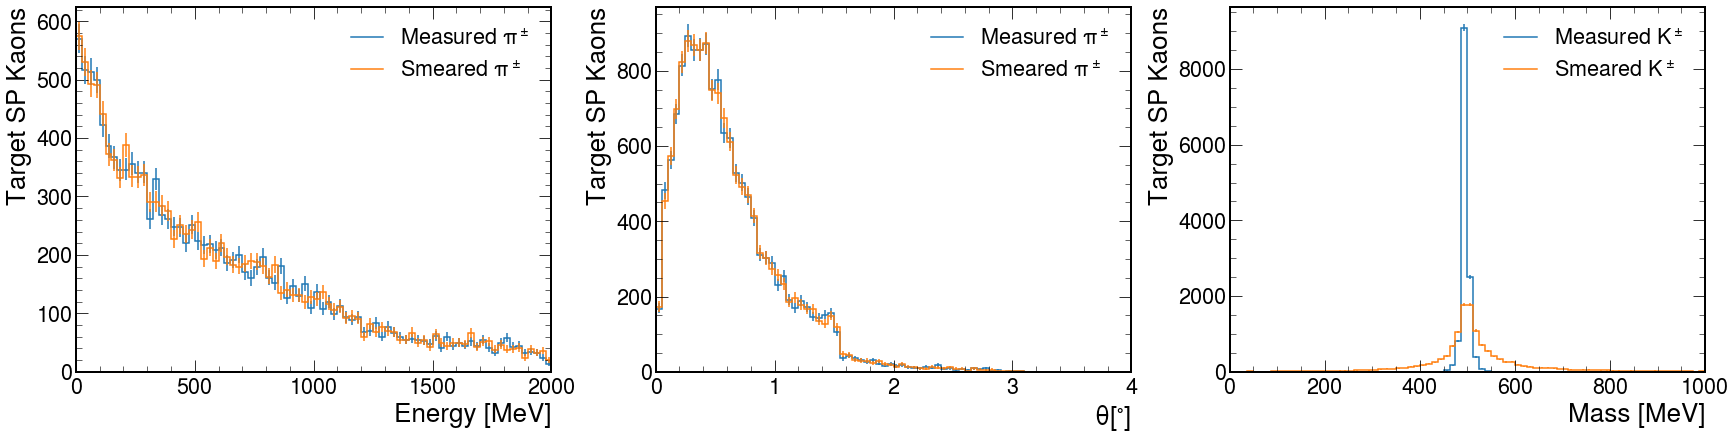

In [8]:
print(hists["Target_pion_ke"])
fig, ax = plt.subplots(1,3,figsize=(24,6), constrained_layout=True)
hist.plot1d(hists["Target_pion_ke"].sum('keS'),ax=ax[0],clear=False);
hist.plot1d(hists["Target_pion_ke"].sum('keOG'),ax=ax[0],clear=False);
leg = ax[0].legend([r'Measured $\pi ^\pm$', r'Smeared $\pi ^\pm$'])

hist.plot1d(hists["Target_pion_theta"].sum('keS'),ax=ax[1],clear=False);
hist.plot1d(hists["Target_pion_theta"].sum('keOG'),ax=ax[1],clear=False);
leg = ax[1].legend([r'Measured $\pi ^\pm$', r'Smeared $\pi ^\pm$'])

hist.plot1d(hists["Target_pion_mass"].sum('keS'),ax=ax[2],clear=False);
hist.plot1d(hists["Target_pion_mass"].sum('keOG'),ax=ax[2],clear=False);
leg = ax[2].legend([r'Measured $K^\pm$', r'Smeared $K^\pm$'])

<Hist (keOG,keS) instance at 0x1285555b0>


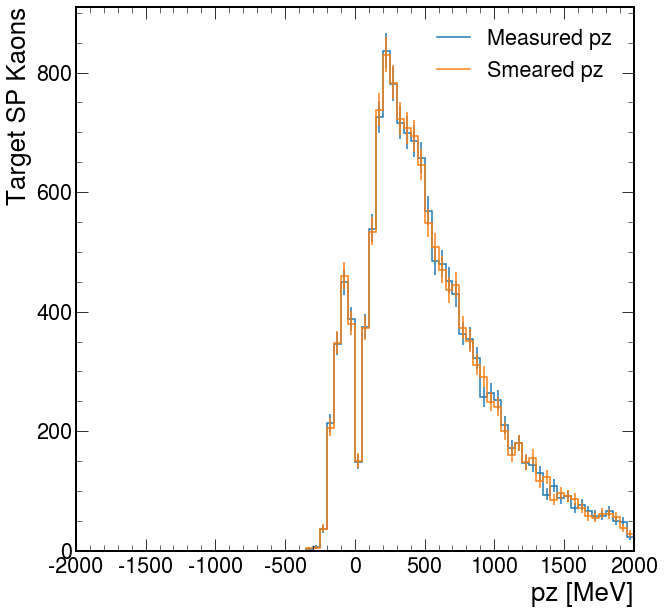

In [9]:
print(hists["Target_pion_pz"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_pion_pz"].sum('keS'),ax=ax,clear=False);
hist.plot1d(hists["Target_pion_pz"].sum('keOG'),ax=ax,clear=False);
leg = ax.legend([r'Measured pz', r'Smeared pz'])